# Title

# Analysis

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import os.path

from scipy import stats
import seaborn as sns

In [3]:
TEST_NAMES = ['rust-wasmedge-fuzzysearch-http', 'rust-spin-whatlang', 'rust-spin-user-manager', 'rust-spin-n-body', 'rust-spin-aes', 'rust-spin-prime-numbers', 'rust-spin-fuzzysearch-http', 'rust-spin-audio-sine-wave', 'rust-wasmedge-whatlang', 'rust-wasmedge-user-manager', 'rust-wasmedge-n-body-socket', 'rust-wasmedge-fuzzysearch-http-socket', 'rust-wasmedge-whatlang-socket', 'rust-wasmedge-prime-numbers-socket', 'rust-wasmedge-n-body', 'rust-wasmedge-aes', 'rust-wasmedge-user-manager-socket', 'rust-wasmedge-prime-numbers', 'rust-wasmedge-audio-sine-wave']

In [4]:
RUNTIMES = ['wasmedge', 'spin']

## Serial Execution

In [303]:
df_serial_execution_kubernetes = pd.DataFrame()
for runtime in RUNTIMES:
  for test in TEST_NAMES:
    if runtime in test:
      file = f'kubernetes/serial/{runtime}/{test}-serial.csv'
      if os.path.isfile(file):
        df_tmp = pd.read_csv(file)
        df_tmp['test_name'] = test
        df_tmp['test_name_no_pre'] = '-'.join(test.split('-',2)[2:])
        df_tmp['runtime'] = runtime
        df_tmp['batch'] = 'kubernetes'
        df_tmp[['response-time', 'status-code', 'test_name', 'runtime', 'batch']].to_csv(f'kubernetes/serial/{runtime}/{test}-serial.2.csv', index=False)
        df_serial_execution_kubernetes = df_serial_execution_kubernetes.append(df_tmp)

In [304]:
df_serial_execution_nomad = pd.DataFrame()
for runtime in RUNTIMES:
  for test in TEST_NAMES:
    if runtime in test:
      file = f'nomad/serial/{runtime}/{test}-serial.csv'
      if os.path.isfile(file):
        df_tmp = pd.read_csv(file)
        df_tmp['test_name'] = test
        df_tmp['test_name_no_pre'] = '-'.join(test.split('-',2)[2:])
        df_tmp['runtime'] = runtime
        df_tmp['batch'] = 'nomad'
        df_tmp[['response-time', 'status-code', 'test_name', 'runtime', 'batch']].to_csv(f'nomad/serial/{runtime}/{test}-serial.2.csv', index=False)
        df_serial_execution_nomad = df_serial_execution_nomad.append(df_tmp)

In [305]:
df_serial_all = pd.DataFrame()
df_serial_all = df_serial_all.append(df_serial_execution_kubernetes)
df_serial_all = df_serial_all.append(df_serial_execution_nomad)

Increasing the default number of shown records to aid data exploration.

In [306]:
pd.set_option('display.max_rows', 500)

Mean execution time per test. Execution method: 5 minutes continuous serial execution with 1 thread.

In [238]:
df_serial_execution_kubernetes[['response-time', 'test_name']].groupby(['test_name']).mean()

response-time
test_name                                           
rust-spin-aes                               0.011141
rust-spin-fuzzysearch-http                  0.038358
rust-spin-n-body                            0.001452
rust-spin-prime-numbers                     0.001442
rust-spin-user-manager                      0.020922
rust-spin-whatlang                          0.001870
rust-wasmedge-aes                           2.042731
rust-wasmedge-audio-sine-wave               0.430446
rust-wasmedge-fuzzysearch-http              2.100707
rust-wasmedge-fuzzysearch-http-socket       2.184230
rust-wasmedge-n-body                        0.072048
rust-wasmedge-n-body-socket                 0.028178
rust-wasmedge-prime-numbers                 0.044578
rust-wasmedge-prime-numbers-socket          0.003822
rust-wasmedge-user-manager                  0.060984
rust-wasmedge-whatlang                      0.062487
rust-wasmedge-whatlang-socket               0.020617

In [239]:
df_serial_execution_nomad[['response-time', 'test_name']].groupby(['test_name']).mean()


response-time
test_name                                           
rust-spin-aes                               0.010067
rust-spin-audio-sine-wave                   0.005291
rust-spin-fuzzysearch-http                  0.035919
rust-spin-n-body                            0.001211
rust-spin-prime-numbers                     0.001169
rust-spin-user-manager                      0.018274
rust-spin-whatlang                          0.001588
rust-wasmedge-aes                           2.112243
rust-wasmedge-audio-sine-wave               0.288933
rust-wasmedge-fuzzysearch-http              2.135603
rust-wasmedge-fuzzysearch-http-socket       2.207937
rust-wasmedge-n-body                        0.070778
rust-wasmedge-n-body-socket                 0.028343
rust-wasmedge-prime-numbers                 0.044395
rust-wasmedge-prime-numbers-socket          0.003761
rust-wasmedge-user-manager                  0.060546
rust-wasmedge-user-manager-socket           0.004097
rust-wasmedge-whatlang                      0.063900
rust-wasmedge-whatlang-socket               0.021915

In [299]:
alpha = 0.05
for runtime in RUNTIMES:
  for test in TEST_NAMES:
    if runtime in test:
      tmp_df_serial_execution_kubernetes = df_serial_execution_kubernetes[(df_serial_execution_kubernetes.test_name == test)]['response-time']
      tmp_df_serial_execution_nomad = df_serial_execution_nomad[(df_serial_execution_nomad.test_name == test)]['response-time']
      if not tmp_df_serial_execution_kubernetes.empty and not tmp_df_serial_execution_nomad.empty:
        statistic, pvalue = stats.mannwhitneyu(tmp_df_serial_execution_kubernetes, tmp_df_serial_execution_nomad, alternative='two-sided')
        if pvalue > alpha:
          print(f'[{test}] Fail to reject H0 - same distribution (statistic={statistic})(p={pvalue})')
        else:
          print(f'[{test}] Reject H0 - different distribution (statistic={statistic})(p={pvalue})')

[rust-wasmedge-fuzzysearch-http] Reject H0 - different distribution (statistic=0.0)(p=4.468913880833234e-48)
[rust-wasmedge-whatlang] Reject H0 - different distribution (statistic=7217508.5)(p=6.883331681850963e-222)
[rust-wasmedge-user-manager] Reject H0 - different distribution (statistic=13198482.0)(p=5.247373812873261e-15)
[rust-wasmedge-n-body-socket] Reject H0 - different distribution (statistic=45935287.0)(p=7.152740936852329e-123)
[rust-wasmedge-fuzzysearch-http-socket] Reject H0 - different distribution (statistic=124.5)(p=2.9208540170244885e-45)
[rust-wasmedge-whatlang-socket] Reject H0 - different distribution (statistic=9147437.0)(p=0.0)
[rust-wasmedge-prime-numbers-socket] Reject H0 - different distribution (statistic=3613976260.5)(p=0.0)
[rust-wasmedge-n-body] Reject H0 - different distribution (statistic=11770077.5)(p=1.4504769207714833e-170)
[rust-wasmedge-aes] Reject H0 - different distribution (statistic=0.0)(p=4.758717892520019e-49)
[rust-wasmedge-prime-numbers] Reje

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_1784066/2346036036.py:6: UserWarning: The figure layout has changed to tight
  serial_execution_avg_bar_plot.fig.tight_layout(w_pad=3)


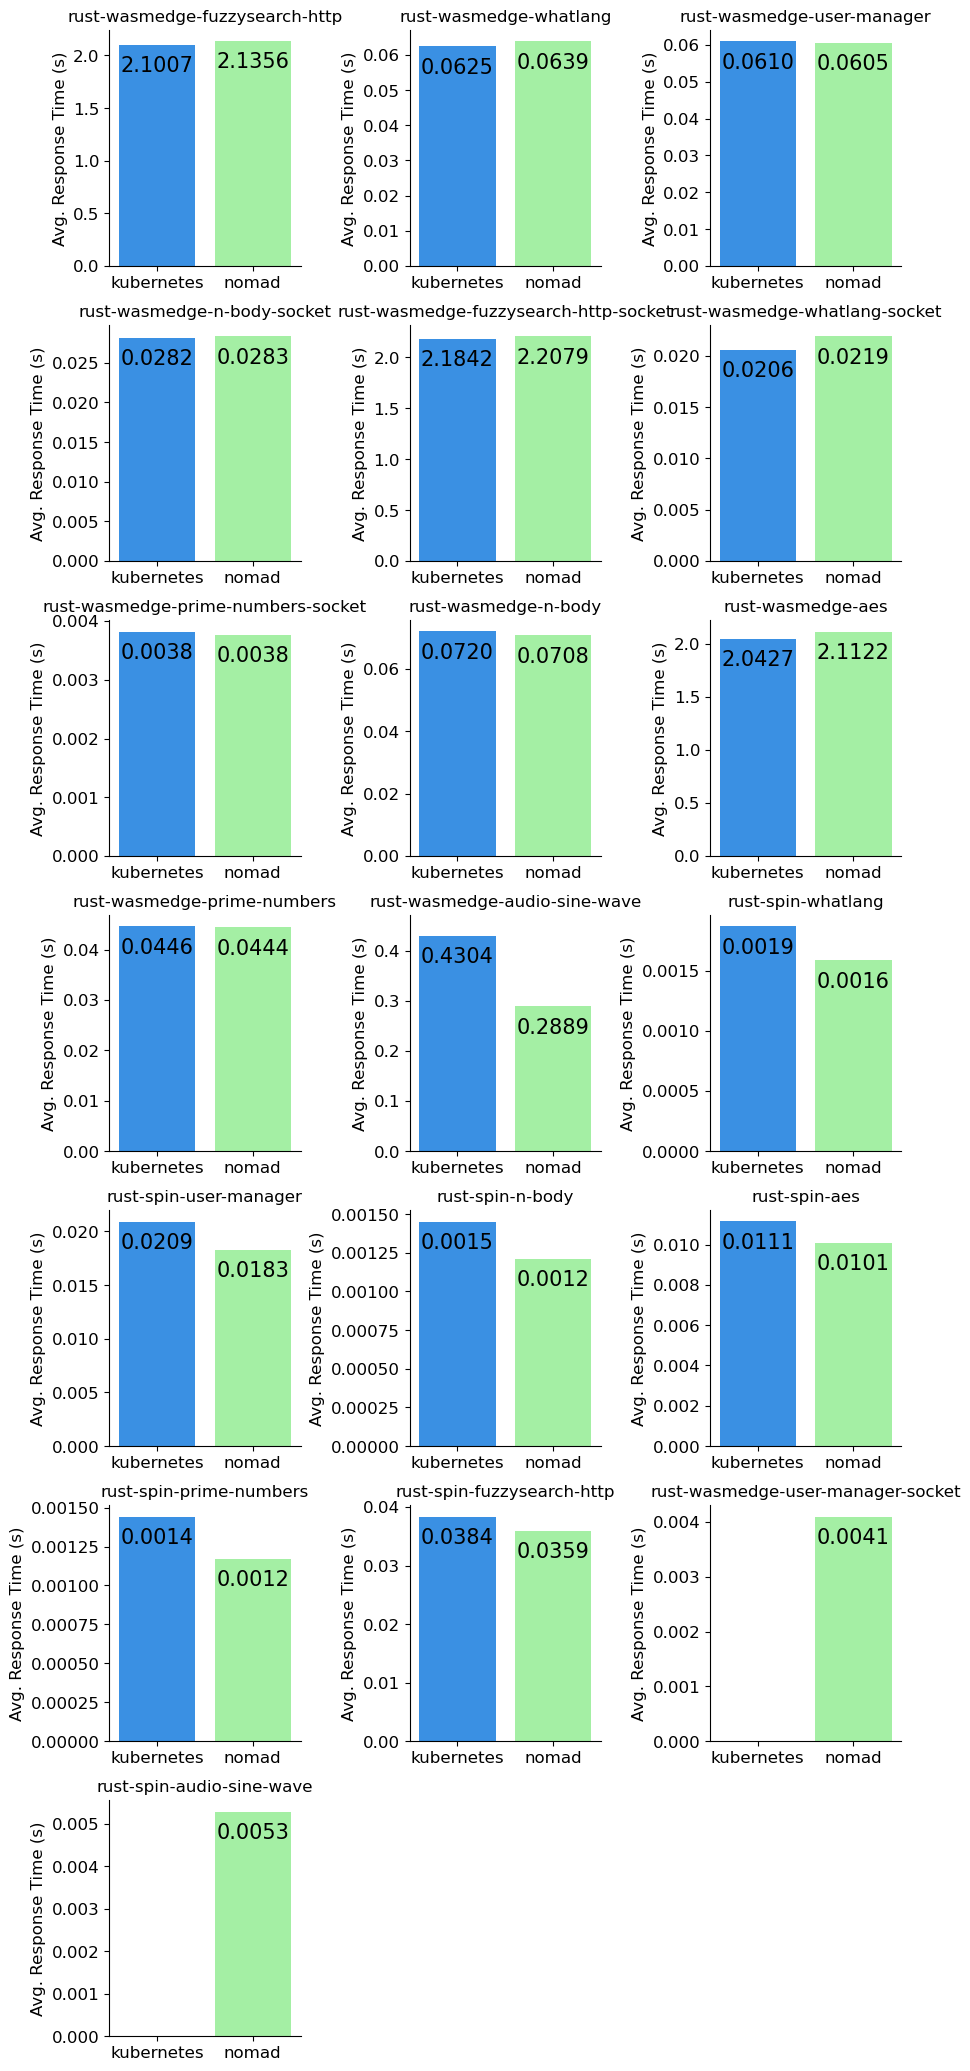

In [272]:
serial_execution_avg_bar_plot = sns.FacetGrid(df_serial_all, col="test_name", hue='batch', col_wrap=3, sharey=False, palette=['dodgerblue', 'palegreen', 'darkorange'],
                                              sharex=False)
serial_execution_avg_bar_plot = serial_execution_avg_bar_plot.map(sns.barplot, 'batch', 'response-time',
                                                                  order=['kubernetes', 'nomad'], errwidth=0)
serial_execution_avg_bar_plot.set_titles('{col_name}', size=12)
serial_execution_avg_bar_plot.fig.tight_layout(w_pad=3)
for ax in serial_execution_avg_bar_plot.axes.ravel():
    ax.set_ylabel('Avg. Response Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=15)
plt.show()

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_1784066/141906507.py:5: UserWarning: The figure layout has changed to tight
  serial_execution_avg_bar_plot.fig.tight_layout(w_pad=3)


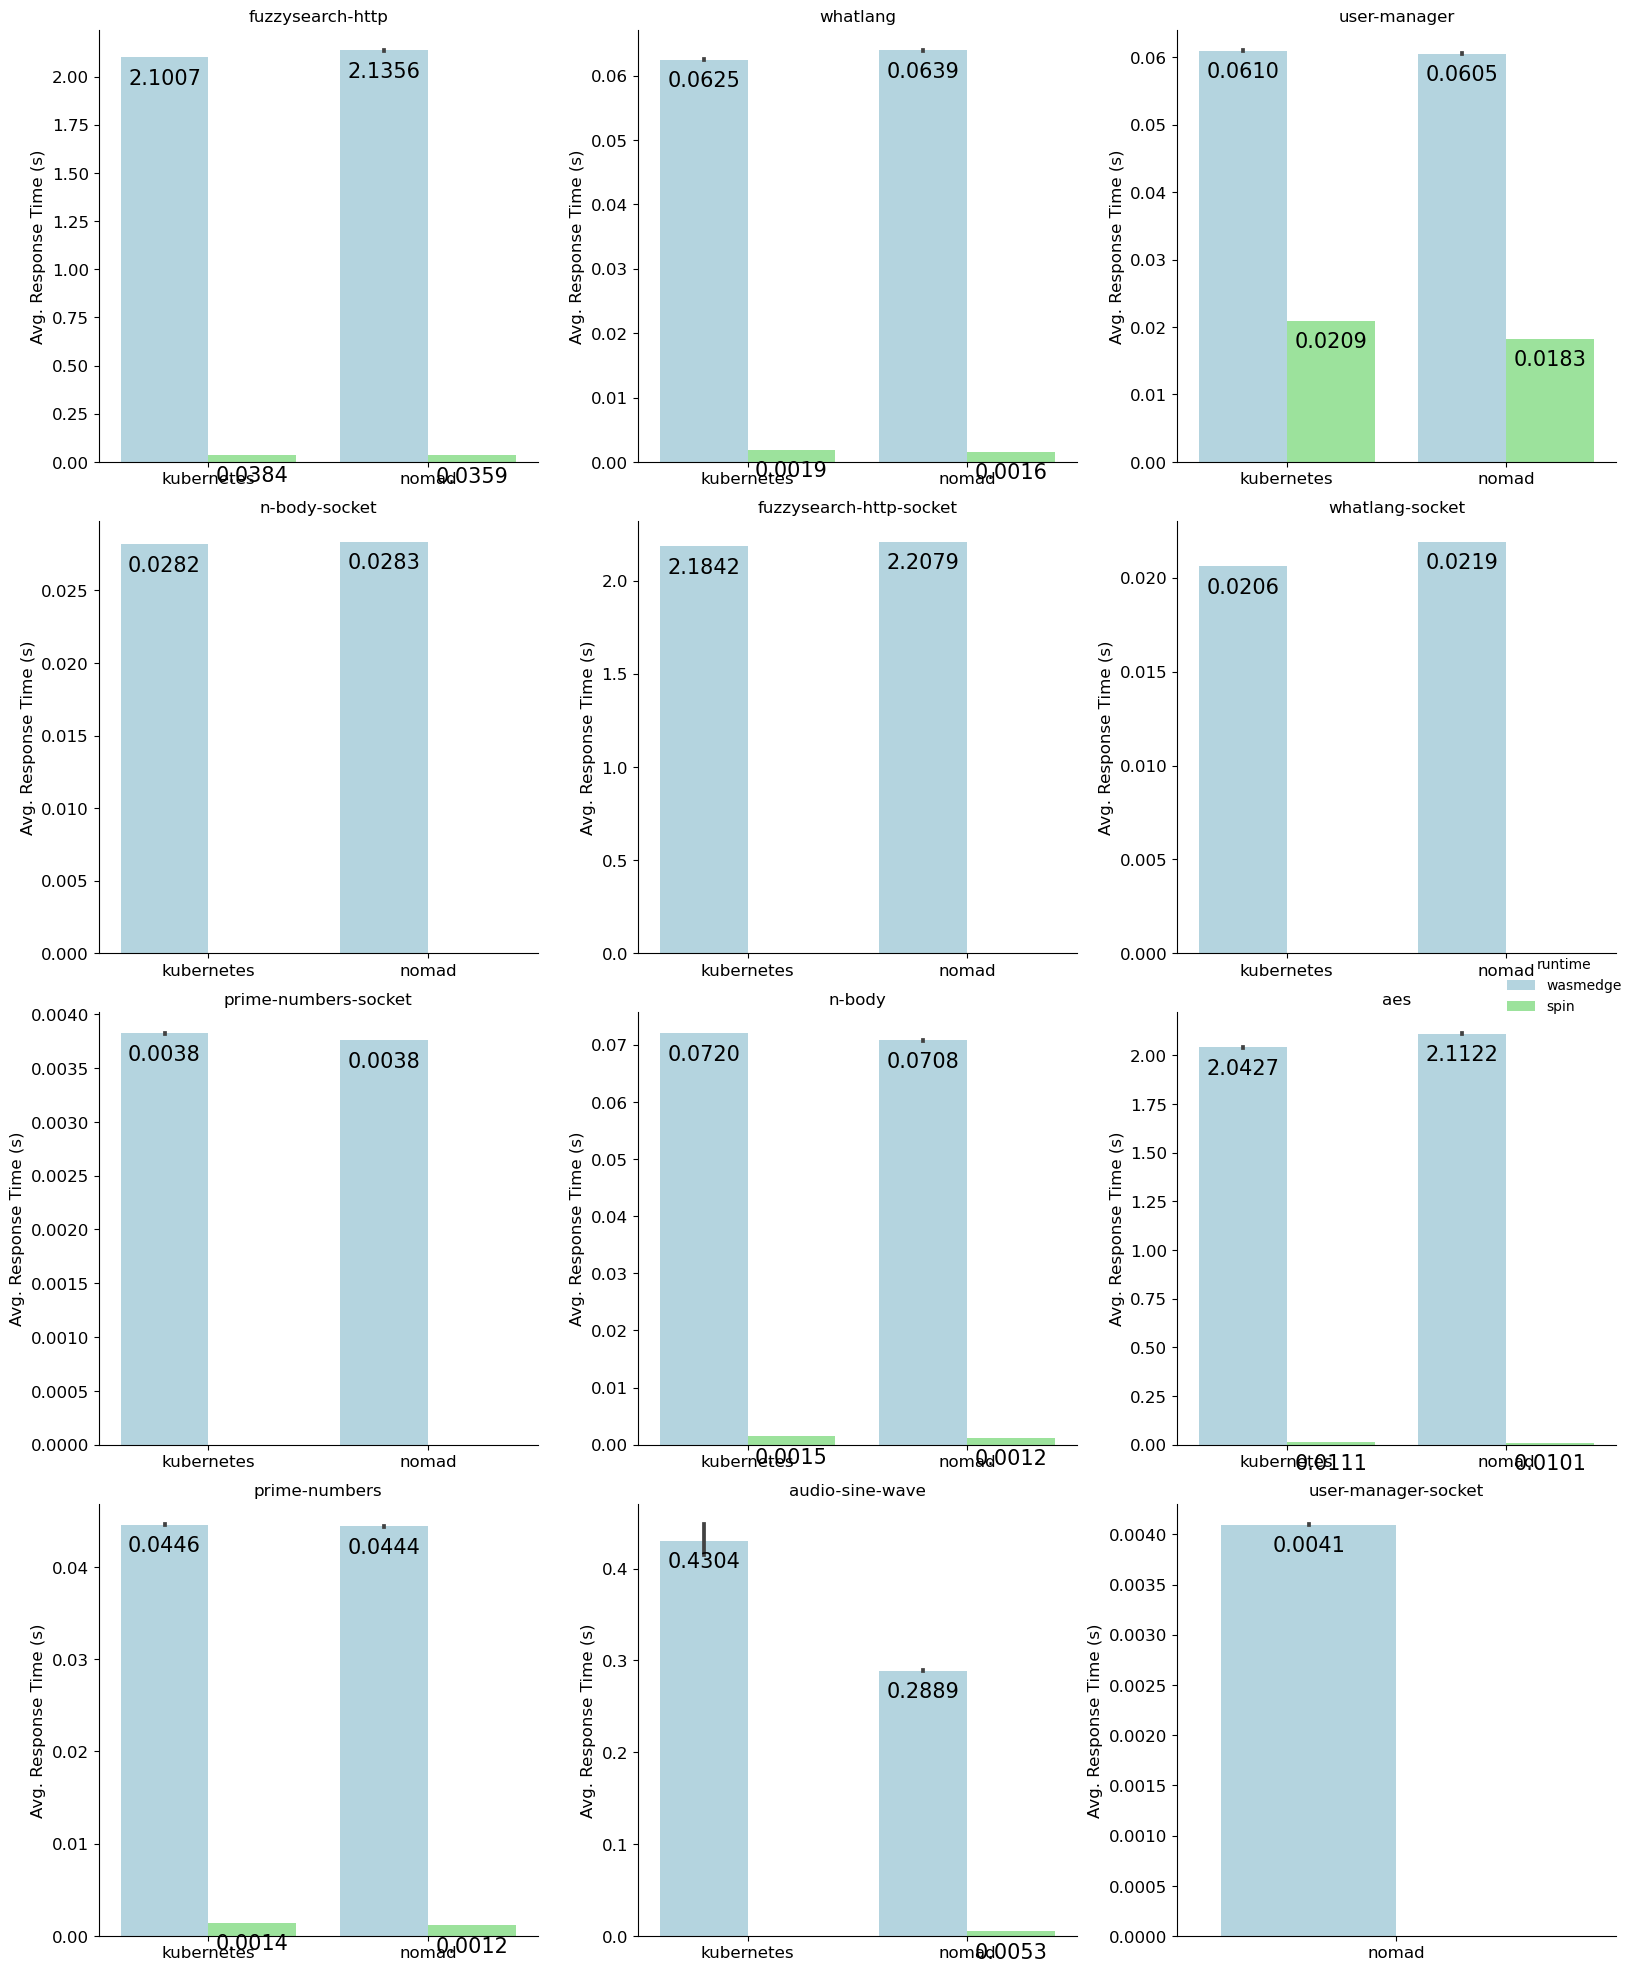

In [242]:
serial_execution_avg_bar_plot = sns.catplot(data=df_serial_all,  col='test_name_no_pre', x='batch', y='response-time',  hue='runtime', col_wrap=3, sharey=False, palette=['lightblue', 'lightgreen', 'darkorange'],
                                              sharex=False, kind='bar')

serial_execution_avg_bar_plot.set_titles('{col_name}', size=12)
serial_execution_avg_bar_plot.fig.tight_layout(w_pad=3)
for ax in serial_execution_avg_bar_plot.axes.ravel():
    ax.set_ylabel('Avg. Response Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=15)
plt.show()

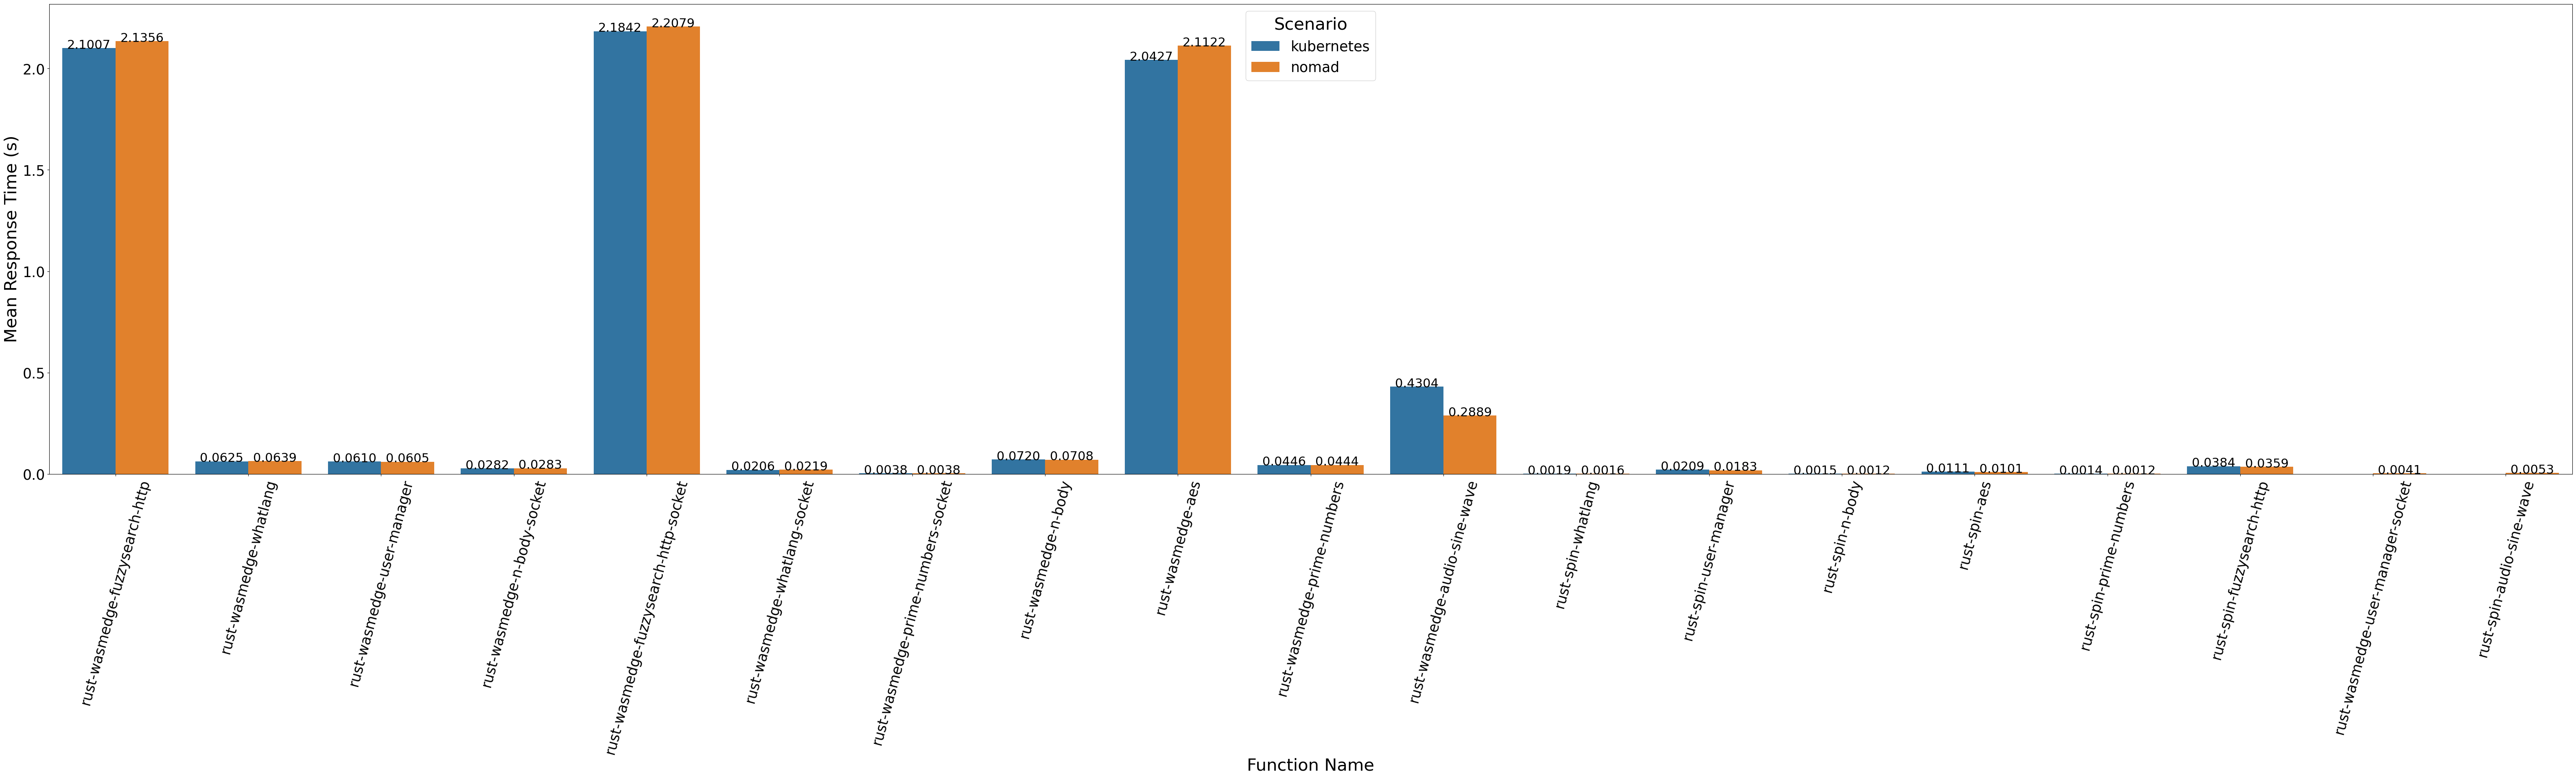

In [243]:
fig = plt.figure(figsize=(80,15))
pl1 = sns.barplot(data=df_serial_all, y="response-time", x="test_name", hue='batch',errorbar=None)
pl1.set_xlabel('Function Name', fontsize=30)
pl1.set_ylabel('Mean Response Time (s)', fontsize=30)
pl1.tick_params(labelsize=25)
plt.xticks(rotation=75)
legend = pl1.legend(title='Scenario', fontsize=25)
plt.setp(legend.get_title(),fontsize=30)

for ax in pl1.patches:
    pl1.annotate(format(ax.get_height(), '.4f'), (ax.get_x() + ax.get_width() / 2., ax.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=22)

fig = pl1.get_figure()
fig.savefig('graphs/01-serial-execution.png', bbox_inches='tight', dpi=300)

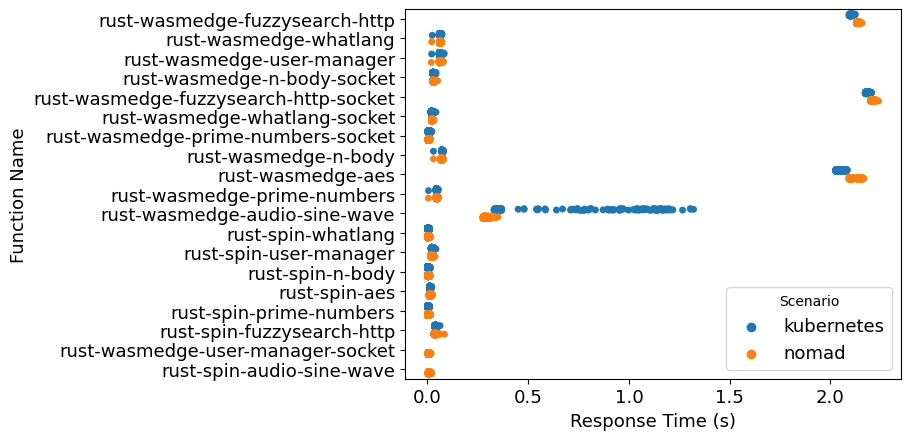

In [244]:
bplot1 = sns.stripplot(data=df_serial_all, y='test_name', x='response-time', hue='batch', dodge=True, jitter=True)
bplot1.set_xlabel('Response Time (s)', fontsize=13)
bplot1.set_ylabel('Function Name', fontsize=13)
bplot1.tick_params(labelsize=13)
bplot1.legend(title='Scenario', fontsize=13, loc='lower right')

fig = bplot1.get_figure()
fig.savefig('graphs/02-serial-execution-stripplot.png', bbox_inches='tight', dpi=300)

In [245]:
for test in TEST_NAMES:
        tmp_std_kubernetes = df_serial_all[(df_serial_all.test_name == test) & (df_serial_all.batch=='kubernetes')]['response-time'].std()
        tmp_std_nomad = df_serial_all[(df_serial_all.test_name == test) & (df_serial_all.batch=='nomad')]['response-time'].std()
        tmp_coefvar_kubernetes = stats.variation(df_serial_all[(df_serial_all.test_name == test) & (df_serial_all.batch=='kubernetes')]['response-time'])
        tmp_coefvar_nomad = stats.variation(df_serial_all[(df_serial_all.test_name == test) & (df_serial_all.batch=='nomad')]['response-time'])
        print(f'STD - [{test}] kubernetes < nomad: {tmp_std_kubernetes<tmp_std_nomad}, {round(tmp_std_kubernetes,4)}<{round(tmp_std_nomad,4)}')
        print(f'COEF VAR - [{test}] kubernetes < nomad: {tmp_coefvar_kubernetes<tmp_coefvar_nomad}, {round(tmp_coefvar_kubernetes,4)}<{round(tmp_coefvar_nomad,4)}')

STD - [rust-wasmedge-fuzzysearch-http] kubernetes < nomad: False, 0.0057<0.0046
COEF VAR - [rust-wasmedge-fuzzysearch-http] kubernetes < nomad: False, 0.0027<0.0021
STD - [rust-spin-whatlang] kubernetes < nomad: True, 0.0002<0.0002
COEF VAR - [rust-spin-whatlang] kubernetes < nomad: True, 0.1136<0.1559
STD - [rust-spin-user-manager] kubernetes < nomad: True, 0.0008<0.0009
COEF VAR - [rust-spin-user-manager] kubernetes < nomad: True, 0.04<0.0478
STD - [rust-spin-n-body] kubernetes < nomad: False, 0.0002<0.0002
COEF VAR - [rust-spin-n-body] kubernetes < nomad: True, 0.1706<0.1821
STD - [rust-spin-aes] kubernetes < nomad: True, 0.0005<0.0005
COEF VAR - [rust-spin-aes] kubernetes < nomad: True, 0.0418<0.052
STD - [rust-spin-prime-numbers] kubernetes < nomad: True, 0.0002<0.0002
COEF VAR - [rust-spin-prime-numbers] kubernetes < nomad: True, 0.1393<0.1867
STD - [rust-spin-fuzzysearch-http] kubernetes < nomad: True, 0.0009<0.0013
COEF VAR - [rust-spin-fuzzysearch-http] kubernetes < nomad: Tru

## Function Deployment

In [38]:
df_function_deployment_kubernetes = pd.DataFrame()
for runtime in RUNTIMES:
  for test in TEST_NAMES:
    if runtime in test:
      file = f'kubernetes/function/{runtime}/{test}-function-deployment.csv'
      if os.path.isfile(file):
        df_tmp = pd.read_csv(file)
        df_tmp['test_name'] = test
        df_tmp['batch'] = 'kubernetes'
        df_tmp['statuscode'] = df_tmp['status-code']
        df_tmp['test_name_no_pre'] = '-'.join(test.split('-',2)[2:])
        df_tmp['runtime'] = runtime
        df_function_deployment_kubernetes = df_function_deployment_kubernetes.append(df_tmp)
df_function_deployment_kubernetes_all = df_function_deployment_kubernetes

In [308]:
df_function_deployment_kubernetes = df_function_deployment_kubernetes.query("statuscode == 200")
df_function_deployment_kubernetes[['response-time', 'test_name']].groupby(['test_name']).mean()

response-time
test_name                                           
rust-spin-aes                               0.013488
rust-spin-fuzzysearch-http                  0.042550
rust-spin-n-body                            0.003312
rust-spin-prime-numbers                     0.003455
rust-spin-user-manager                      0.485509
rust-spin-whatlang                          0.003886
rust-wasmedge-aes                           2.069772
rust-wasmedge-audio-sine-wave               0.494992
rust-wasmedge-fuzzysearch-http              2.598685
rust-wasmedge-fuzzysearch-http-socket       2.194831
rust-wasmedge-n-body                        0.029998
rust-wasmedge-n-body-socket                 0.029477
rust-wasmedge-prime-numbers                 0.005808
rust-wasmedge-prime-numbers-socket          0.005541
rust-wasmedge-user-manager                  0.023918
rust-wasmedge-user-manager-socket           0.620430
rust-wasmedge-whatlang                      0.031044
rust-wasmedge-whatlang-socket               0.030198

In [37]:
df_function_deployment_nomad = pd.DataFrame()
for runtime in RUNTIMES:
  for test in TEST_NAMES:
    if runtime in test:
      file = f'nomad/function/{runtime}/{test}-function-deployment.csv'
      if os.path.isfile(file):
        df_tmp = pd.read_csv(file)
        df_tmp['test_name'] = test
        df_tmp['batch'] = 'nomad'
        df_tmp['statuscode'] = df_tmp['status-code']
        df_tmp['test_name_no_pre'] = '-'.join(test.split('-',2)[2:])
        df_tmp['runtime'] = runtime
        df_function_deployment_nomad = df_function_deployment_nomad.append(df_tmp)
df_function_deployment_nomad_all = df_function_deployment_nomad

In [263]:
df_function_deployment_nomad = df_function_deployment_nomad.query("statuscode == 200")
df_function_deployment_nomad[['response-time', 'test_name']].groupby(['test_name']).mean()

response-time
test_name                                           
rust-spin-aes                               0.012478
rust-spin-audio-sine-wave                   0.007382
rust-spin-fuzzysearch-http                  0.039524
rust-spin-n-body                            0.003150
rust-spin-prime-numbers                     0.003162
rust-spin-user-manager                      0.023124
rust-spin-whatlang                          0.003742
rust-wasmedge-aes                           2.107681
rust-wasmedge-audio-sine-wave               0.311463
rust-wasmedge-fuzzysearch-http              2.150587
rust-wasmedge-fuzzysearch-http-socket       2.234556
rust-wasmedge-n-body                        0.029975
rust-wasmedge-n-body-socket                 0.029894
rust-wasmedge-prime-numbers                 0.005040
rust-wasmedge-prime-numbers-socket          0.004757
rust-wasmedge-user-manager                  0.020950
rust-wasmedge-user-manager-socket           0.005172
rust-wasmedge-whatlang                      0.031503
rust-wasmedge-whatlang-socket               0.031232

In [40]:
df_function_deployment_all = pd.DataFrame()
df_function_deployment_all = df_function_deployment_all.append(df_function_deployment_kubernetes)
df_function_deployment_all = df_function_deployment_all.append(df_function_deployment_nomad)

df_function_deployment_all_all = pd.DataFrame()
df_function_deployment_all_all = df_function_deployment_all_all.append(df_function_deployment_kubernetes_all)
df_function_deployment_all_all = df_function_deployment_all_all.append(df_function_deployment_nomad_all)

In [251]:
alpha = 0.05
for runtime in RUNTIMES:
  for test in TEST_NAMES:
    if runtime in test:
      tmp_df_function_deployment_kubernetes = df_function_deployment_kubernetes[(df_function_deployment_kubernetes.test_name == test)]['response-time']
      tmp_df_function_deployment_nomad = df_function_deployment_nomad[(df_function_deployment_nomad.test_name == test)]['response-time']
      if not tmp_df_function_deployment_kubernetes.empty and not tmp_df_function_deployment_nomad.empty:
        statistic, pvalue = stats.mannwhitneyu(tmp_df_function_deployment_kubernetes, tmp_df_function_deployment_nomad, alternative='two-sided')
        if pvalue > alpha:
          print(f'[{test}] Fail to reject H0 - same distribution (statistic={statistic})(p={pvalue})')
        else:
          print(f'[{test}] Reject H0 - different distribution (statistic={statistic})(p={pvalue})')

[rust-wasmedge-fuzzysearch-http] Reject H0 - different distribution (statistic=461.5)(p=0.006805119417148624)
[rust-wasmedge-whatlang] Fail to reject H0 - same distribution (statistic=1462.0)(p=0.22411988593446008)
[rust-wasmedge-user-manager] Reject H0 - different distribution (statistic=2777.5)(p=3.601169909577241e-08)
[rust-wasmedge-n-body-socket] Reject H0 - different distribution (statistic=2231.5)(p=0.032861780250009825)
[rust-wasmedge-fuzzysearch-http-socket] Reject H0 - different distribution (statistic=25.0)(p=1.7897158729500655e-12)
[rust-wasmedge-whatlang-socket] Reject H0 - different distribution (statistic=361.5)(p=1.1816346970616447e-10)
[rust-wasmedge-prime-numbers-socket] Reject H0 - different distribution (statistic=2926.0)(p=2.0328142687698294e-15)
[rust-wasmedge-n-body] Fail to reject H0 - same distribution (statistic=1861.0)(p=0.16525499465464366)
[rust-wasmedge-aes] Reject H0 - different distribution (statistic=399.0)(p=2.037679086940604e-12)
[rust-wasmedge-user-ma

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_2037985/1786246983.py:6: UserWarning: The figure layout has changed to tight
  function_deployment_avg_bar_plot.fig.tight_layout(w_pad=3)


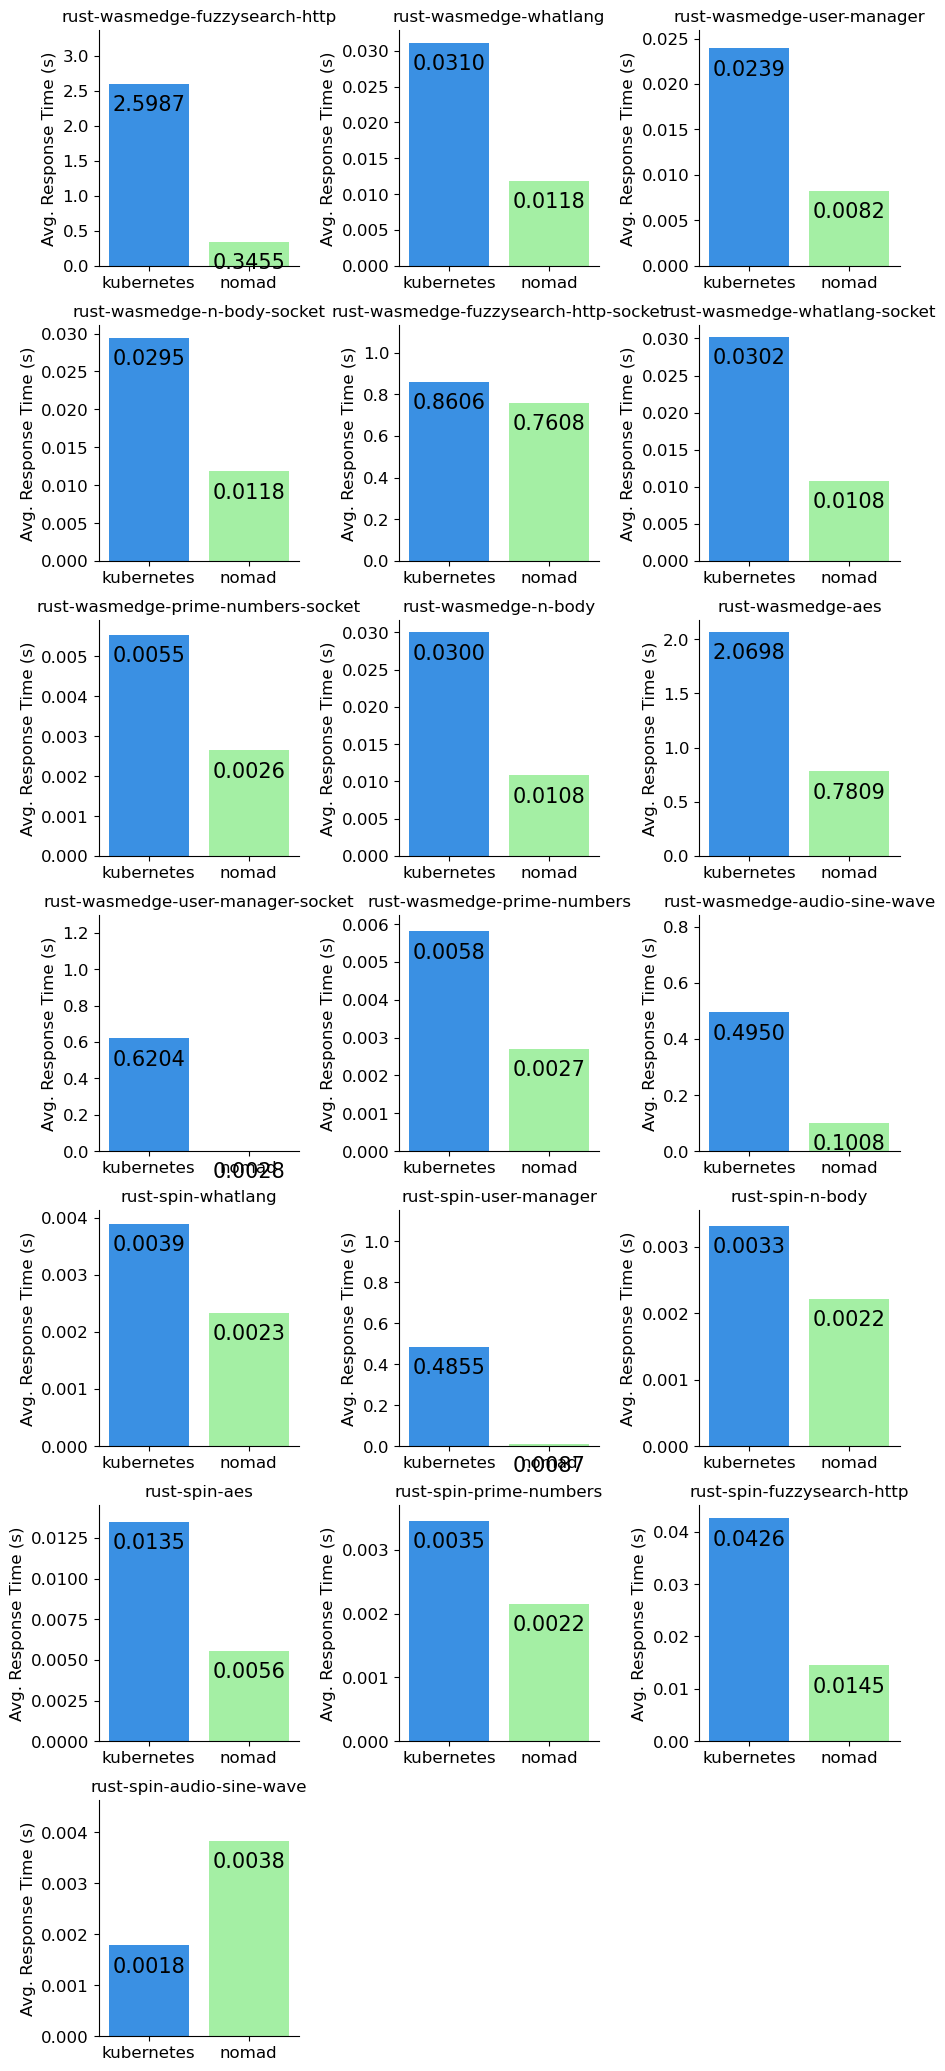

In [48]:
function_deployment_avg_bar_plot = sns.FacetGrid(df_function_deployment_all, col="test_name", hue='batch', col_wrap=3, sharey=False, palette=['dodgerblue', 'palegreen', 'darkorange'],
                                              sharex=False)
function_deployment_avg_bar_plot = function_deployment_avg_bar_plot.map(sns.barplot, 'batch', 'response-time',
                                                                  order=['kubernetes', 'nomad'], errwidth=0)
function_deployment_avg_bar_plot.set_titles('{col_name}', size=12)
function_deployment_avg_bar_plot.fig.tight_layout(w_pad=3)
for ax in function_deployment_avg_bar_plot.axes.ravel():
    ax.set_ylabel('Avg. Response Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=15)
plt.show()

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_2037985/740404940.py:5: UserWarning: The figure layout has changed to tight
  function_execution_avg_bar_plot.fig.tight_layout(w_pad=3)


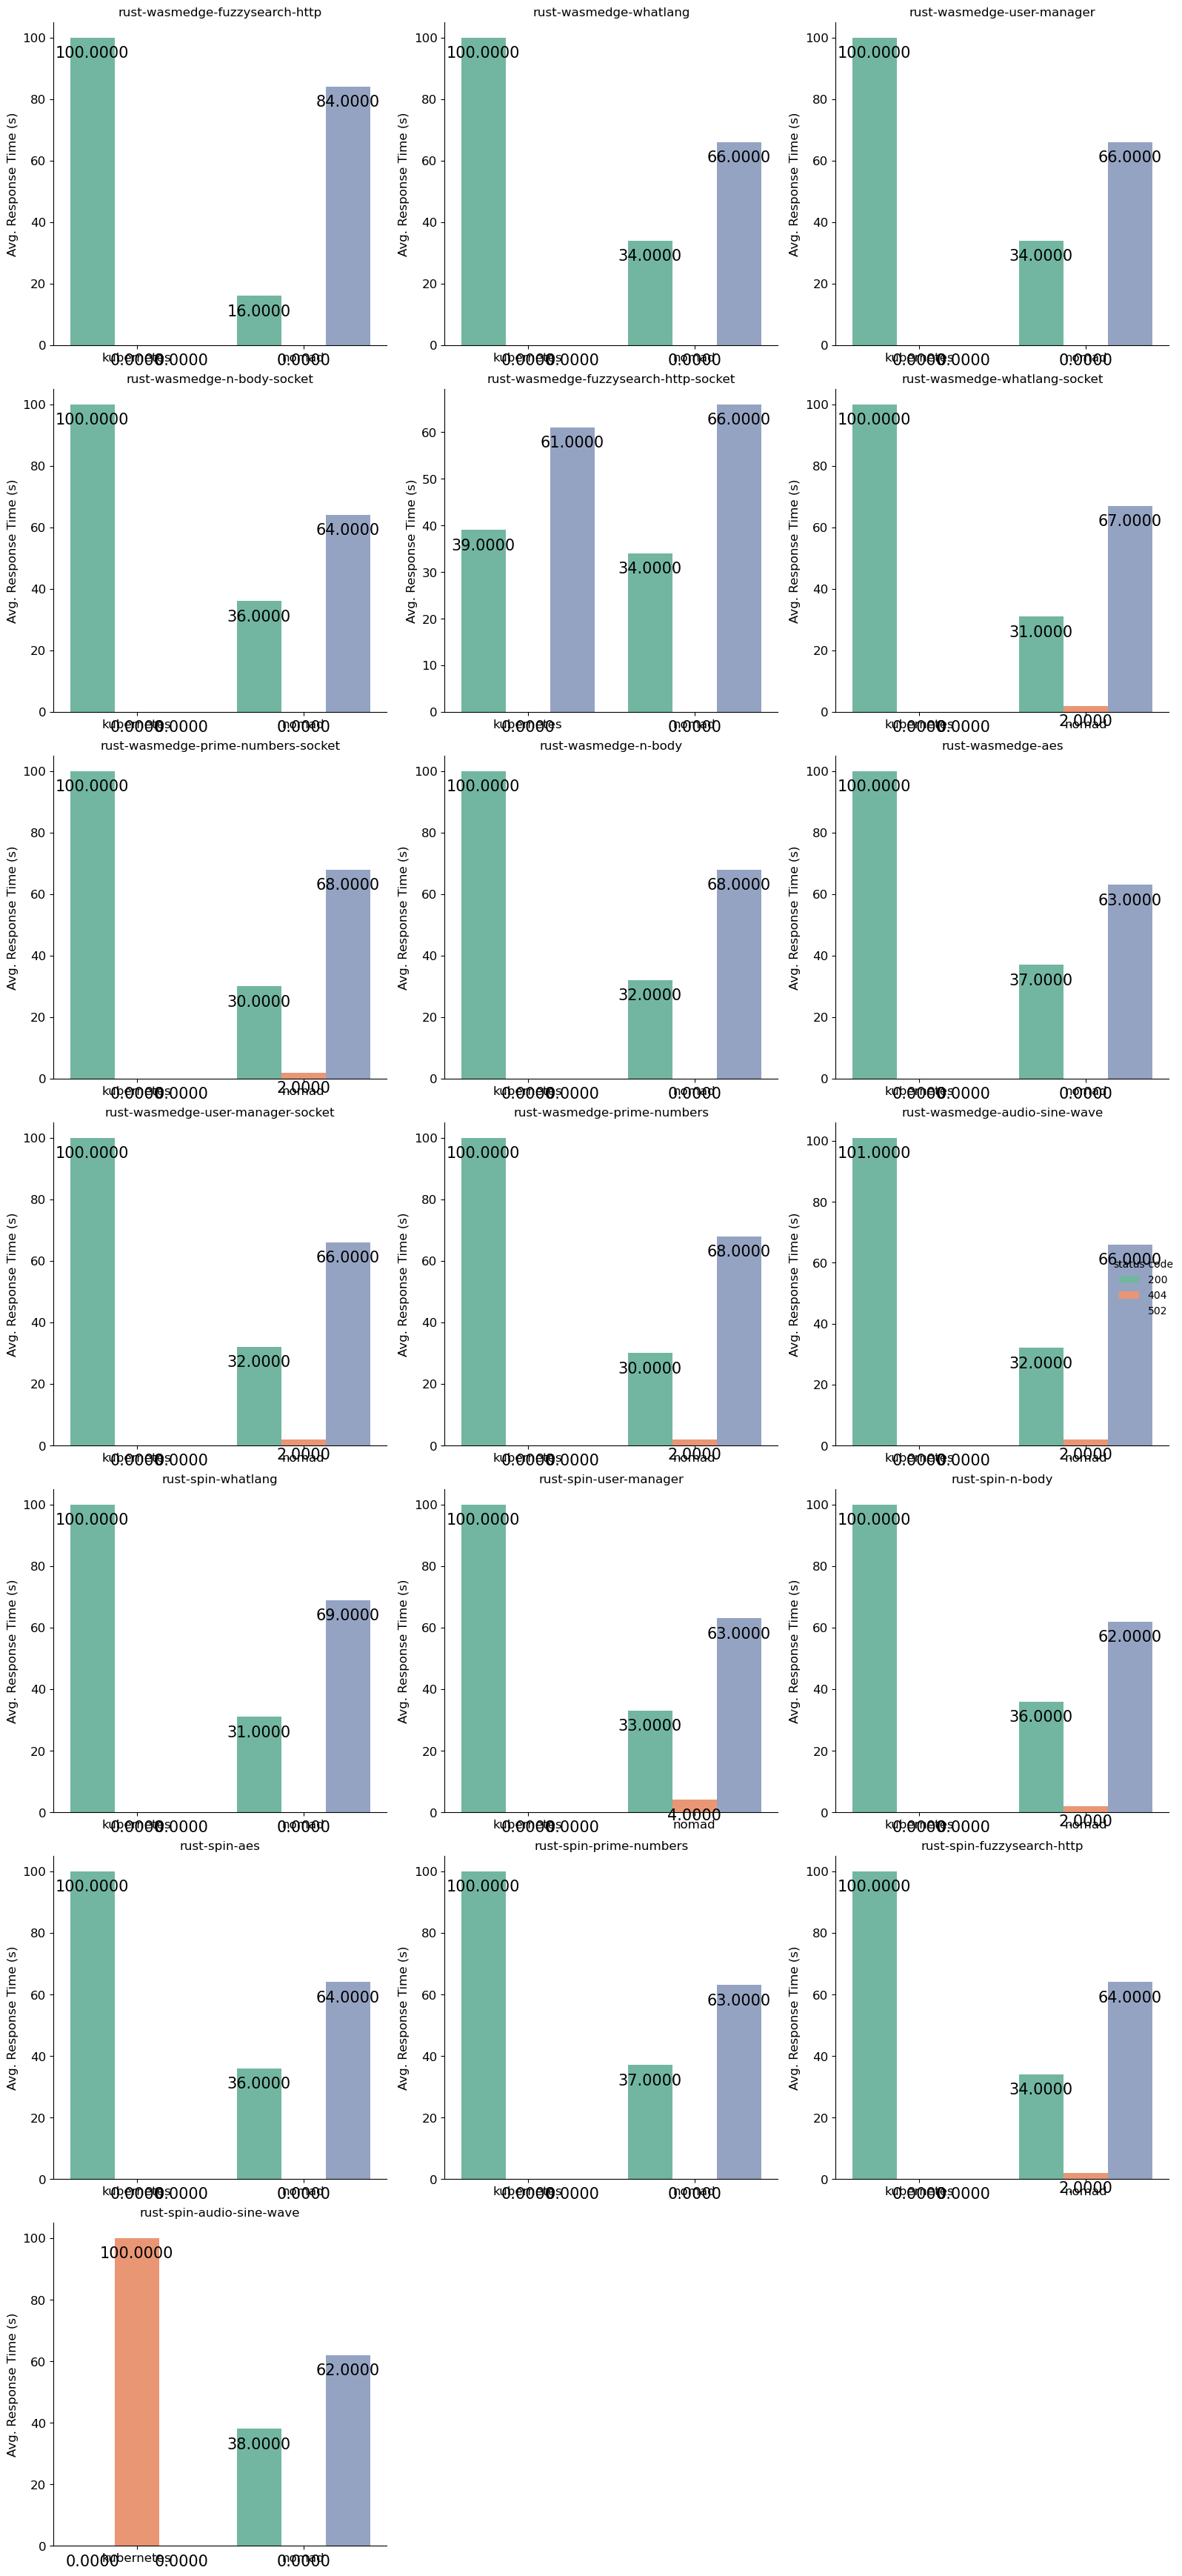

In [49]:
function_execution_avg_bar_plot = sns.catplot(data=df_function_deployment_all_all,  col='test_name', x='batch',  hue='status-code', col_wrap=3, sharey=False, palette="Set2",
                                              sharex=False, kind='count')

function_execution_avg_bar_plot.set_titles('{col_name}', size=12)
function_execution_avg_bar_plot.fig.tight_layout(w_pad=3)
for ax in function_execution_avg_bar_plot.axes.ravel():
    ax.set_ylabel('Count', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=15)
plt.show()

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_2037985/2792380126.py:5: UserWarning: The figure layout has changed to tight
  function_execution_avg_bar_plot.fig.tight_layout(w_pad=3)


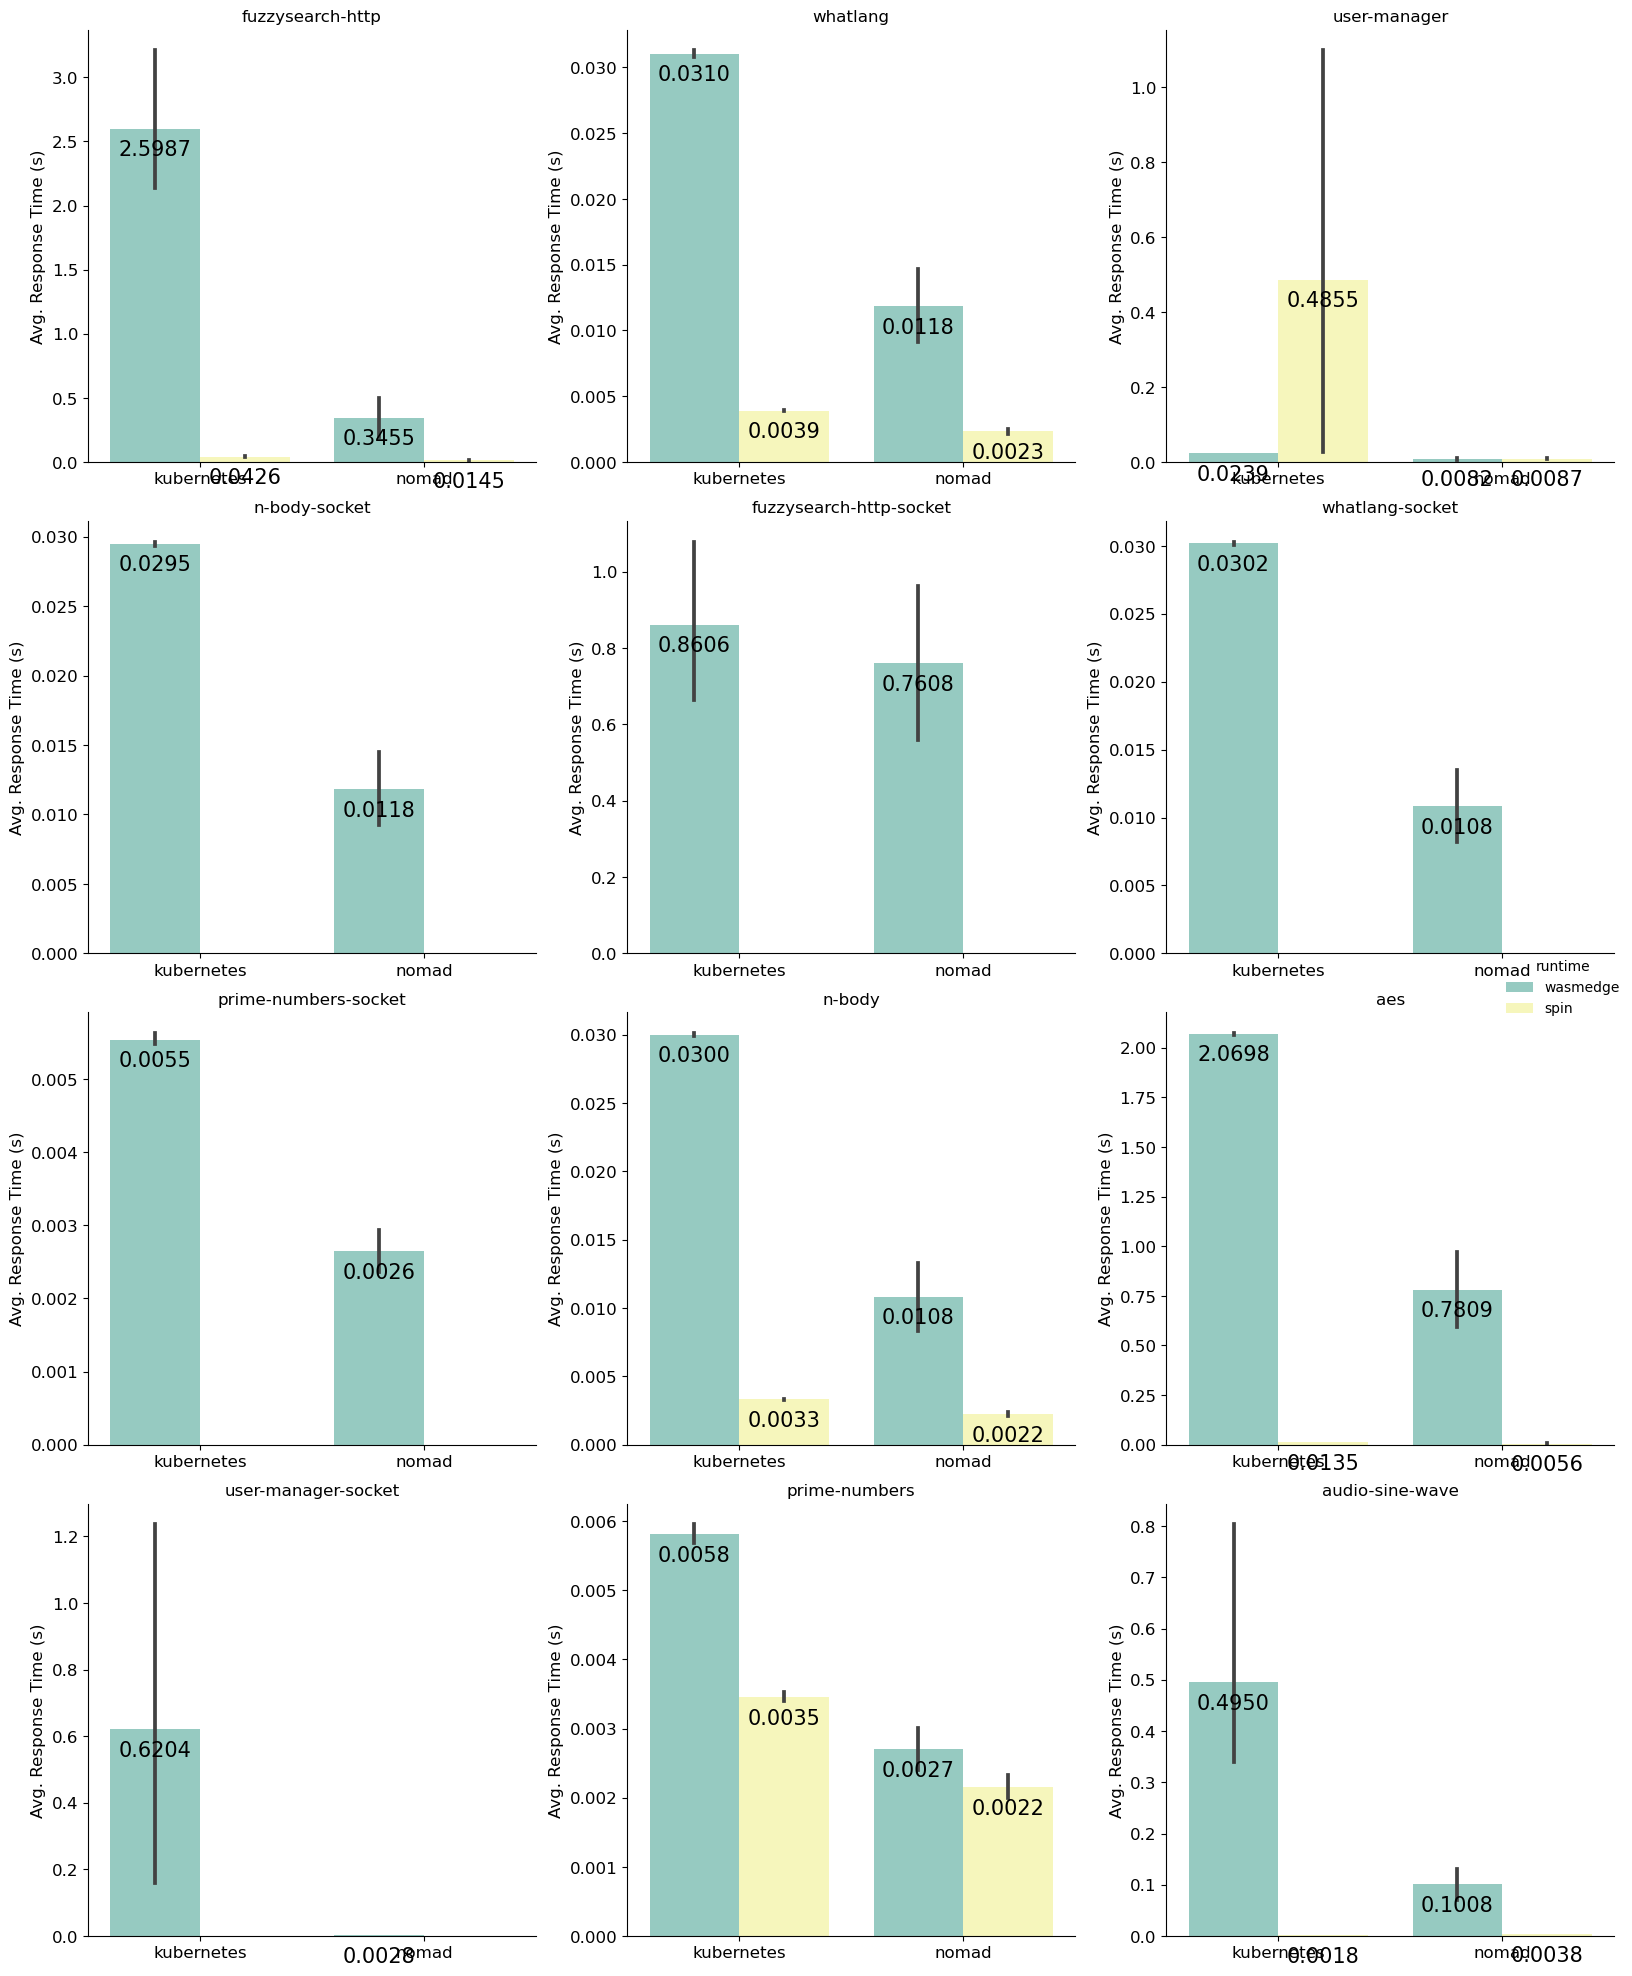

In [50]:
function_execution_avg_bar_plot = sns.catplot(data=df_function_deployment_all,  col='test_name_no_pre', x='batch', y='response-time',  hue='runtime', col_wrap=3, sharey=False, palette="Set3",
                                              sharex=False, kind='bar')

function_execution_avg_bar_plot.set_titles('{col_name}', size=12)
function_execution_avg_bar_plot.fig.tight_layout(w_pad=3)
for ax in function_execution_avg_bar_plot.axes.ravel():
    ax.set_ylabel('Avg. Response Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=15)
plt.show()

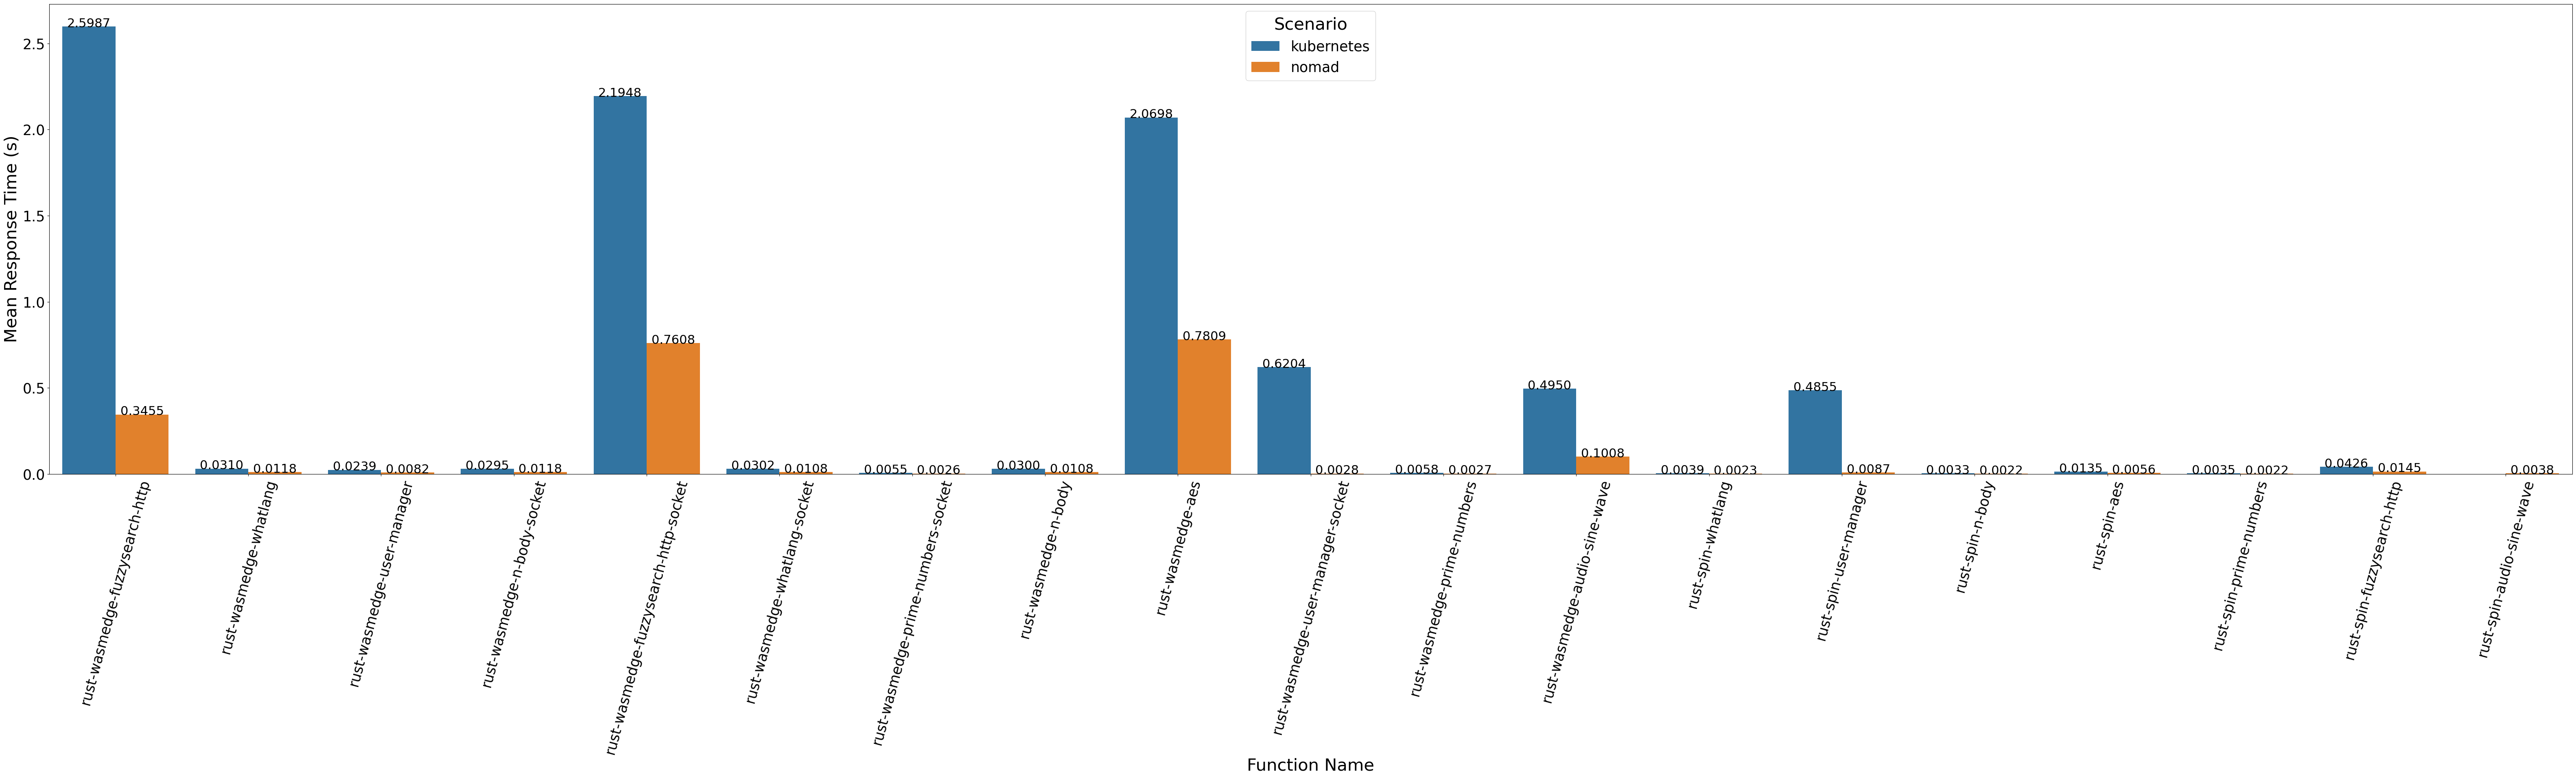

In [321]:
fig = plt.figure(figsize=(80,15))
sns.set_palette(['dodgerblue', 'palegreen', 'darkorange'])
pl2 = sns.barplot(data=df_function_deployment_all, y="response-time", x="test_name", hue='batch',errorbar=None)
pl2.set_xlabel('Function Name', fontsize=30)
pl2.set_ylabel('Mean Response Time (s)', fontsize=30)
pl2.tick_params(labelsize=25)
plt.xticks(rotation=75)
legend = pl2.legend(title='Scenario', fontsize=25)
plt.setp(legend.get_title(),fontsize=30)

for ax in pl2.patches:
    pl2.annotate(format(ax.get_height(), '.4f'), (ax.get_x() + ax.get_width() / 2., ax.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=22)

fig = pl2.get_figure()
fig.savefig('graphs/04-first-exec-after-instantiation.png', bbox_inches='tight', dpi=300)

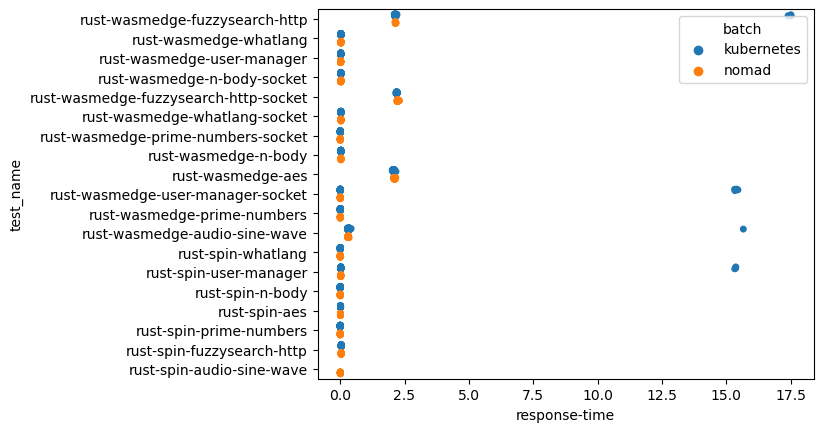

In [281]:
bplot2 = sns.stripplot(data=df_function_deployment_all, y='test_name', x='response-time', hue='batch', dodge=True, jitter=True)

In [256]:
for test in TEST_NAMES:
    tmp_std_kubernetes = df_function_deployment_all[(df_function_deployment_all.test_name == test) & (df_function_deployment_all.batch=='kubernetes')]['response-time'].std()
    tmp_std_nomad = df_function_deployment_all[(df_function_deployment_all.test_name == test) & (df_function_deployment_all.batch=='nomad')]['response-time'].std()
    print(f'STD - [{test}] kubernetes < nomad: {tmp_std_kubernetes<tmp_std_nomad}, {round(tmp_std_kubernetes,4)}<{round(tmp_std_nomad,4)}')

STD - [rust-wasmedge-fuzzysearch-http] kubernetes < nomad: False, 2.6283<0.0093
STD - [rust-spin-whatlang] kubernetes < nomad: True, 0.0002<0.0005
STD - [rust-spin-user-manager] kubernetes < nomad: False, 2.6266<0.0033
STD - [rust-spin-n-body] kubernetes < nomad: False, 0.0003<0.0003
STD - [rust-spin-aes] kubernetes < nomad: False, 0.0014<0.0009
STD - [rust-spin-prime-numbers] kubernetes < nomad: True, 0.0003<0.0007
STD - [rust-spin-fuzzysearch-http] kubernetes < nomad: False, 0.0017<0.0013
STD - [rust-spin-audio-sine-wave] kubernetes < nomad: False, nan<0.0007
STD - [rust-wasmedge-whatlang] kubernetes < nomad: True, 0.0013<0.002
STD - [rust-wasmedge-user-manager] kubernetes < nomad: False, 0.0039<0.0026
STD - [rust-wasmedge-n-body-socket] kubernetes < nomad: True, 0.0008<0.0026
STD - [rust-wasmedge-fuzzysearch-http-socket] kubernetes < nomad: True, 0.0126<0.0201
STD - [rust-wasmedge-whatlang-socket] kubernetes < nomad: True, 0.0006<0.0007
STD - [rust-wasmedge-prime-numbers-socket] kub

## Concurrent Execution

Execution method: 1 minute continuous execution by 5 threads, each thread limited to 5 requests per second (max 25 requests per second for 1 minute, total 1500 requests).

In [30]:
df_concurrent_execution_kubernetes = pd.DataFrame()
for runtime in RUNTIMES:
  for test in TEST_NAMES:
    if runtime in test:
      file = f'kubernetes/concurrent/{runtime}/{test}-concurrent-execution.csv'
      if os.path.isfile(file):
        df_tmp = pd.read_csv(file)
        df_tmp['test_name'] = test
        df_tmp['batch'] = 'kubernetes'
        df_tmp['test_name_no_pre'] = '-'.join(test.split('-',2)[2:])
        df_tmp['runtime'] = runtime
        df_concurrent_execution_kubernetes = df_concurrent_execution_kubernetes.append(df_tmp)

In [31]:
df_concurrent_execution_kubernetes[['response-time', 'test_name']].groupby(['test_name']).mean()

response-time
test_name                                           
rust-spin-aes                               0.022386
rust-spin-fuzzysearch-http                  0.102409
rust-spin-n-body                            0.003955
rust-spin-prime-numbers                     0.003600
rust-spin-user-manager                      0.075383
rust-spin-whatlang                          0.004722
rust-wasmedge-aes                           9.685094
rust-wasmedge-audio-sine-wave               4.336915
rust-wasmedge-fuzzysearch-http              9.852482
rust-wasmedge-fuzzysearch-http-socket      10.221616
rust-wasmedge-n-body                        0.083253
rust-wasmedge-n-body-socket                 0.082969
rust-wasmedge-prime-numbers                 0.009791
rust-wasmedge-prime-numbers-socket          0.010666
rust-wasmedge-user-manager                  0.055213
rust-wasmedge-whatlang                      0.057982
rust-wasmedge-whatlang-socket               0.060199

In [32]:
df_concurrent_execution_nomad = pd.DataFrame()
for runtime in RUNTIMES:
  for test in TEST_NAMES:
    if runtime in test:
      file = f'nomad/concurrent/{runtime}/{test}-concurrent-execution.csv'
      if os.path.isfile(file):
        df_tmp = pd.read_csv(file)
        df_tmp['test_name'] = test
        df_tmp['batch'] = 'nomad'
        df_tmp['test_name_no_pre'] = '-'.join(test.split('-',2)[2:])
        df_tmp['runtime'] = runtime
        df_concurrent_execution_nomad = df_concurrent_execution_nomad.append(df_tmp)

In [316]:
df_concurrent_execution_nomad[['response-time', 'test_name']].groupby(['test_name']).mean()

response-time
test_name                                           
rust-spin-aes                               0.027841
rust-spin-audio-sine-wave                   0.014631
rust-spin-fuzzysearch-http                  0.074966
rust-spin-n-body                            0.003095
rust-spin-prime-numbers                     0.003122
rust-spin-user-manager                      0.047101
rust-spin-whatlang                          0.004324
rust-wasmedge-aes                          10.075691
rust-wasmedge-audio-sine-wave               1.554938
rust-wasmedge-fuzzysearch-http             10.022906
rust-wasmedge-fuzzysearch-http-socket      10.446848
rust-wasmedge-n-body                        0.081993
rust-wasmedge-n-body-socket                 0.140144
rust-wasmedge-prime-numbers                 0.009288
rust-wasmedge-prime-numbers-socket          0.010164
rust-wasmedge-user-manager                  0.052597
rust-wasmedge-user-manager-socket           0.011257
rust-wasmedge-whatlang                      0.059614
rust-wasmedge-whatlang-socket               0.064162

In [33]:
df_concurrent_execution_all = pd.DataFrame()
df_concurrent_execution_all = df_concurrent_execution_all.append(df_concurrent_execution_kubernetes)
df_concurrent_execution_all = df_concurrent_execution_all.append(df_concurrent_execution_nomad)

In [290]:
alpha = 0.05
for runtime in RUNTIMES:
  for test in TEST_NAMES:
    if runtime in test:
      tmp_df_concurrent_execution_kubernetes = df_concurrent_execution_kubernetes[(df_concurrent_execution_kubernetes.test_name == test)]['response-time']
      tmp_df_concurrent_execution_nomad = df_concurrent_execution_nomad[(df_concurrent_execution_nomad.test_name == test)]['response-time']
      if not tmp_df_concurrent_execution_kubernetes.empty and not tmp_df_concurrent_execution_nomad.empty:
        statistic, pvalue = stats.mannwhitneyu(tmp_df_concurrent_execution_kubernetes, tmp_df_concurrent_execution_nomad, alternative='two-sided')
        if pvalue > alpha:
          print(f'[{test}] Fail to reject H0 - same distribution (statistic={statistic})(p={pvalue})')
        else:
          print(f'[{test}] Reject H0 - different distribution (statistic={statistic})(p={pvalue})')

[rust-wasmedge-fuzzysearch-http] Fail to reject H0 - same distribution (statistic=404.0)(p=0.07258597979920872)
[rust-wasmedge-whatlang] Reject H0 - different distribution (statistic=973793.0)(p=1.8347296923070126e-10)
[rust-wasmedge-user-manager] Reject H0 - different distribution (statistic=1412093.5)(p=1.0160559575349322e-33)
[rust-wasmedge-n-body-socket] Reject H0 - different distribution (statistic=511392.5)(p=1.6123548925410724e-139)
[rust-wasmedge-fuzzysearch-http-socket] Reject H0 - different distribution (statistic=118.0)(p=2.102290087703021e-07)
[rust-wasmedge-whatlang-socket] Reject H0 - different distribution (statistic=921454.0)(p=9.410885445972129e-18)
[rust-wasmedge-prime-numbers-socket] Reject H0 - different distribution (statistic=1282985.0)(p=2.7125412381456464e-11)
[rust-wasmedge-n-body] Reject H0 - different distribution (statistic=1335864.5)(p=6.110809150786111e-19)
[rust-wasmedge-aes] Reject H0 - different distribution (statistic=126.0)(p=8.474143450420233e-08)
[r

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_1784066/2192074451.py:6: UserWarning: The figure layout has changed to tight
  concurrent_execution_avg_bar_plot.fig.tight_layout(w_pad=3)


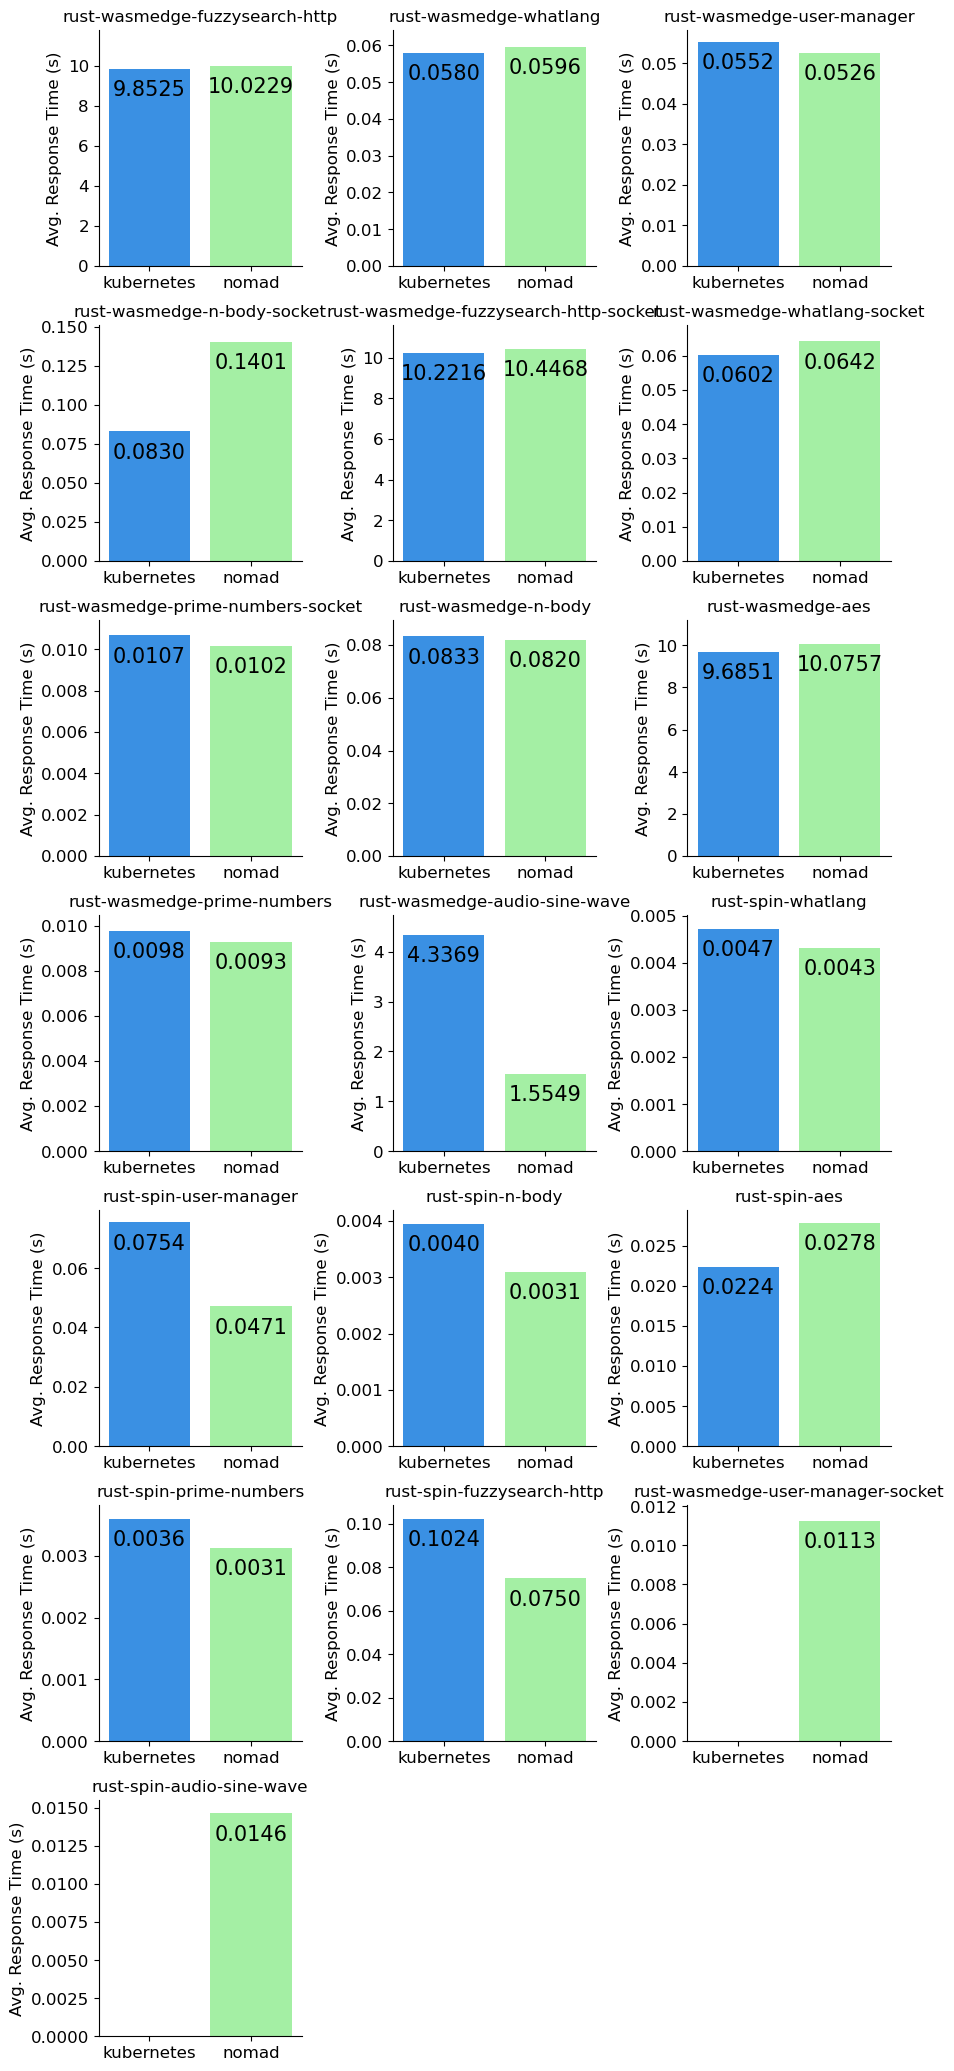

In [319]:
concurrent_execution_avg_bar_plot = sns.FacetGrid(df_concurrent_execution_all, col="test_name", hue='batch', col_wrap=3, sharey=False, palette=['dodgerblue', 'palegreen', 'darkorange'],
                                                 sharex=False)
concurrent_execution_avg_bar_plot = concurrent_execution_avg_bar_plot.map(sns.barplot, 'batch', 'response-time',
                                                                        order=['kubernetes', 'nomad'], errwidth=0)
concurrent_execution_avg_bar_plot.set_titles('{col_name}', size=12)
concurrent_execution_avg_bar_plot.fig.tight_layout(w_pad=3)
for ax in concurrent_execution_avg_bar_plot.axes.ravel():
    ax.set_ylabel('Avg. Response Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=15)
plt.show()

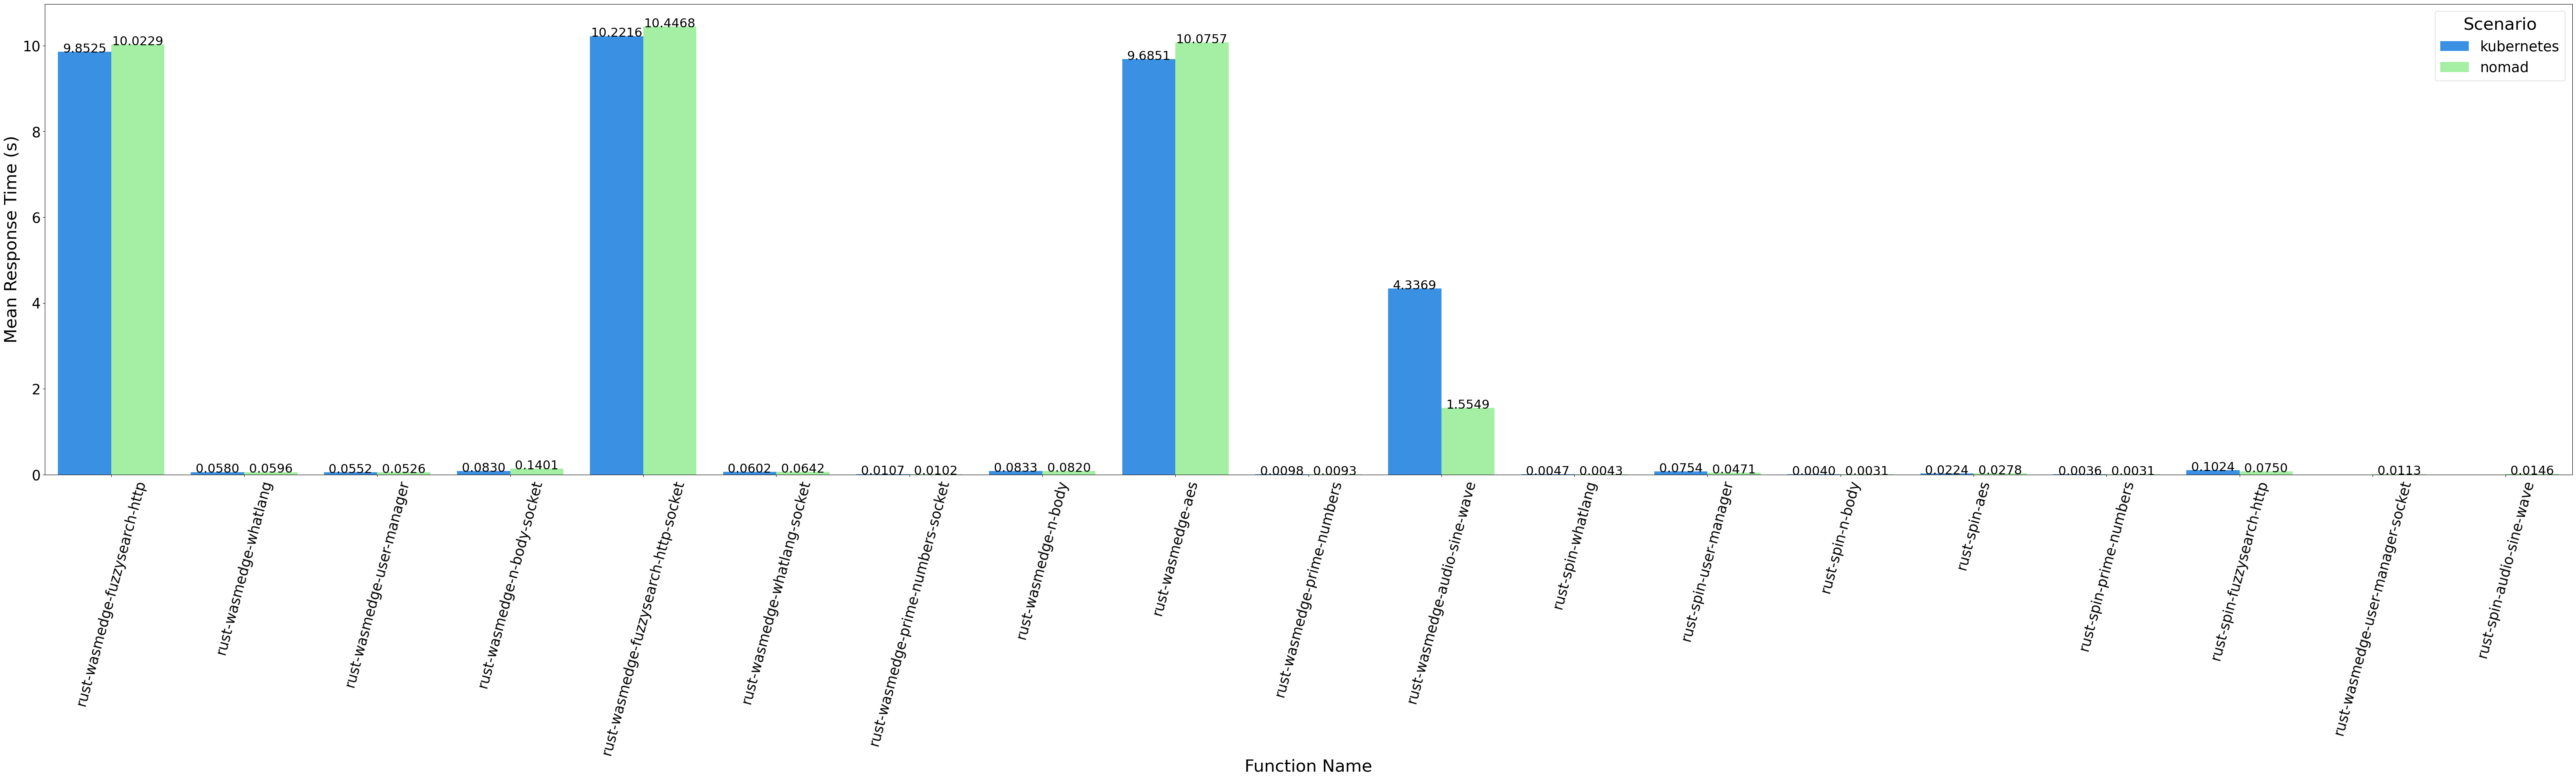

In [34]:
fig = plt.figure(figsize=(80,15))
sns.set_palette(['dodgerblue', 'palegreen', 'darkorange'])
pl3 = sns.barplot(data=df_concurrent_execution_all, y="response-time", x="test_name", hue='batch',errorbar=None)

pl3.set_xlabel('Function Name', fontsize=30)
pl3.set_ylabel('Mean Response Time (s)', fontsize=30)
pl3.tick_params(labelsize=25)
plt.xticks(rotation=75)
legend = pl3.legend(title='Scenario', fontsize=25, loc='upper right')
plt.setp(legend.get_title(),fontsize=30)

for ax in pl3.patches:
    pl3.annotate(format(ax.get_height(), '.4f'), (ax.get_x() + ax.get_width() / 2., ax.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=22)

fig = pl3.get_figure()
fig.savefig('graphs/05-concurrent-execution.png', bbox_inches='tight', dpi=300)


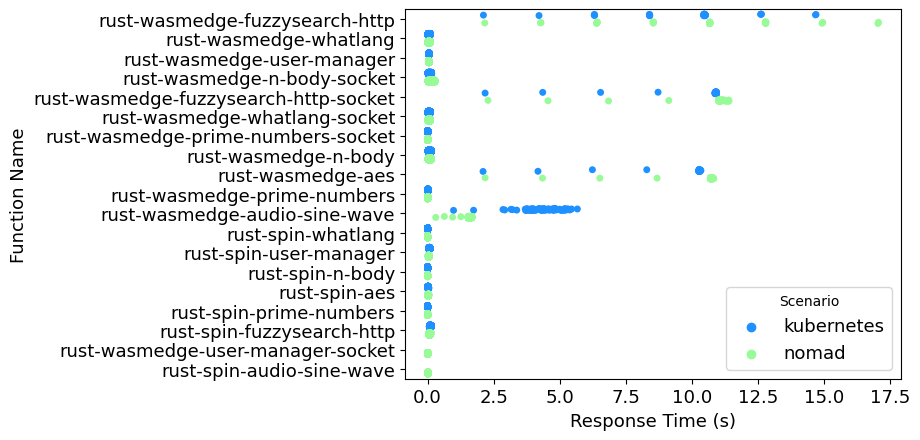

In [35]:
sns.set_palette(['dodgerblue', 'palegreen', 'darkorange'])
bplot3 = sns.stripplot(data=df_concurrent_execution_all, y='test_name', x='response-time', hue='batch', dodge=True, jitter=True)

bplot3.set_xlabel('Response Time (s)', fontsize=13)
bplot3.set_ylabel('Function Name', fontsize=13)
bplot3.tick_params(labelsize=13)
bplot3.legend(title='Scenario', fontsize=13, loc='lower right')

fig = bplot3.get_figure()
fig.savefig('graphs/06-concurrent-execution-stripplot.png', bbox_inches='tight', dpi=300)

In [326]:
for test in TEST_NAMES:
    tmp_std_kubernetes = df_concurrent_execution_all[(df_concurrent_execution_all.test_name == test) & (df_concurrent_execution_all.batch=='kubernetes')]['response-time'].std()
    tmp_std_nomad = df_concurrent_execution_all[(df_concurrent_execution_all.test_name == test) & (df_concurrent_execution_all.batch=='nomad')]['response-time'].std()
    tmp_coefvar_kubernetes = stats.variation(df_concurrent_execution_all[(df_concurrent_execution_all.test_name == test) & (df_concurrent_execution_all.batch=='kubernetes')]['response-time'])
    tmp_coefvar_nomad = stats.variation(df_concurrent_execution_all[(df_concurrent_execution_all.test_name == test) & (df_concurrent_execution_all.batch=='nomad')]['response-time'])
    print(f'STD - [{test}] kubernetes < nomad: {tmp_std_kubernetes<tmp_std_nomad}, {round(tmp_std_kubernetes,4)}<{round(tmp_std_nomad,4)}')
    print(f'COEF VAR - [{test}] kubernetes < nomad: {tmp_coefvar_kubernetes<tmp_coefvar_nomad}, {round(tmp_coefvar_kubernetes,4)}<{round(tmp_coefvar_nomad,4)}')

STD - [rust-wasmedge-fuzzysearch-http] kubernetes < nomad: True, 2.5901<3.6663
COEF VAR - [rust-wasmedge-fuzzysearch-http] kubernetes < nomad: True, 0.2589<0.3602
STD - [rust-spin-whatlang] kubernetes < nomad: False, 0.0011<0.0009
COEF VAR - [rust-spin-whatlang] kubernetes < nomad: False, 0.2346<0.1969
STD - [rust-spin-user-manager] kubernetes < nomad: False, 0.0077<0.0056
COEF VAR - [rust-spin-user-manager] kubernetes < nomad: True, 0.1027<0.1179
STD - [rust-spin-n-body] kubernetes < nomad: False, 0.0008<0.0006
COEF VAR - [rust-spin-n-body] kubernetes < nomad: False, 0.2099<0.189
STD - [rust-spin-aes] kubernetes < nomad: False, 0.0078<0.0044
COEF VAR - [rust-spin-aes] kubernetes < nomad: False, 0.3499<0.1595
STD - [rust-spin-prime-numbers] kubernetes < nomad: False, 0.0007<0.0006
COEF VAR - [rust-spin-prime-numbers] kubernetes < nomad: True, 0.1846<0.1909
STD - [rust-spin-fuzzysearch-http] kubernetes < nomad: False, 0.0216<0.0209
COEF VAR - [rust-spin-fuzzysearch-http] kubernetes < no

## Function Instantiation Time


In [12]:
df_deployment_time_kubernetes = pd.read_csv(f'kubernetes/kube-init.csv')
df_deployment_time_kubernetes['batch'] = 'kubernetes'

df_deployment_time_nomad = pd.read_csv(f'nomad/nomad-init.csv')
df_deployment_time_nomad['batch'] = 'nomad'

In [13]:
print(df_deployment_time_kubernetes[['init_time', 'test_name']].groupby(['test_name']).mean())
print(df_deployment_time_nomad[['init_time', 'test_name']].groupby(['test_name']).mean())

                                       init_time
test_name                                       
rust-spin-aes                           0.808000
rust-spin-fuzzysearch-http              0.852917
rust-spin-n-body                        0.691418
rust-spin-prime-numbers                 0.769970
rust-spin-user-manager                  0.823538
rust-spin-whatlang                      0.860136
rust-wasmedge-aes                       0.483100
rust-wasmedge-audio-sine-wave           0.489161
rust-wasmedge-fuzzysearch-http          0.498089
rust-wasmedge-fuzzysearch-http-socket   0.487220
rust-wasmedge-n-body                    0.491463
rust-wasmedge-n-body-socket             0.493057
rust-wasmedge-prime-numbers             0.529768
rust-wasmedge-prime-numbers-socket      0.490368
rust-wasmedge-user-manager              0.496581
rust-wasmedge-user-manager-socket       0.490725
rust-wasmedge-whatlang                  0.505917
rust-wasmedge-whatlang-socket           0.485590
                    

In [14]:
df_deployment_time_all = pd.DataFrame()
df_deployment_time_all = df_deployment_time_all.append(df_deployment_time_kubernetes)
df_deployment_time_all = df_deployment_time_all.append(df_deployment_time_nomad)

In [24]:
alpha = 0.05
for test in TEST_NAMES:
    tmp_df_deployment_time_kubernetes = df_deployment_time_kubernetes[(df_deployment_time_kubernetes.test_name == test)]['init_time']
    tmp_df_deployment_time_nomad = df_deployment_time_nomad[(df_deployment_time_nomad.test_name == test)]['init_time']
    if not tmp_df_deployment_time_kubernetes.empty and not tmp_df_deployment_time_nomad.empty:
      statistic, pvalue = stats.mannwhitneyu(tmp_df_deployment_time_kubernetes, tmp_df_deployment_time_nomad, alternative='two-sided')
      if pvalue > alpha:
        print(f'[{test}] Fail to reject H0 - same distribution (statistic={statistic})(p={pvalue})')
      else:
        print(f'[{test}] Reject H0 - different distribution (statistic={statistic})(p={pvalue})')


[rust-wasmedge-fuzzysearch-http] Reject H0 - different distribution (statistic=10000.0)(p=2.561999346290125e-34)
[rust-spin-whatlang] Reject H0 - different distribution (statistic=10000.0)(p=2.562143669163401e-34)
[rust-spin-user-manager] Reject H0 - different distribution (statistic=10000.0)(p=2.561999346290125e-34)
[rust-spin-n-body] Reject H0 - different distribution (statistic=10000.0)(p=2.562143669163401e-34)
[rust-spin-aes] Reject H0 - different distribution (statistic=10000.0)(p=2.562143669163401e-34)
[rust-spin-prime-numbers] Reject H0 - different distribution (statistic=10000.0)(p=2.562143669163401e-34)
[rust-spin-fuzzysearch-http] Reject H0 - different distribution (statistic=10000.0)(p=2.562143669163401e-34)
[rust-wasmedge-whatlang] Reject H0 - different distribution (statistic=10000.0)(p=2.561999346290125e-34)
[rust-wasmedge-user-manager] Reject H0 - different distribution (statistic=10000.0)(p=2.561999346290125e-34)
[rust-wasmedge-n-body-socket] Reject H0 - different distr

/usr/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_2037985/2300130465.py:6: UserWarning: The figure layout has changed to tight
  deployment_time_avg_bar_plot.fig.tight_layout(w_pad=3)


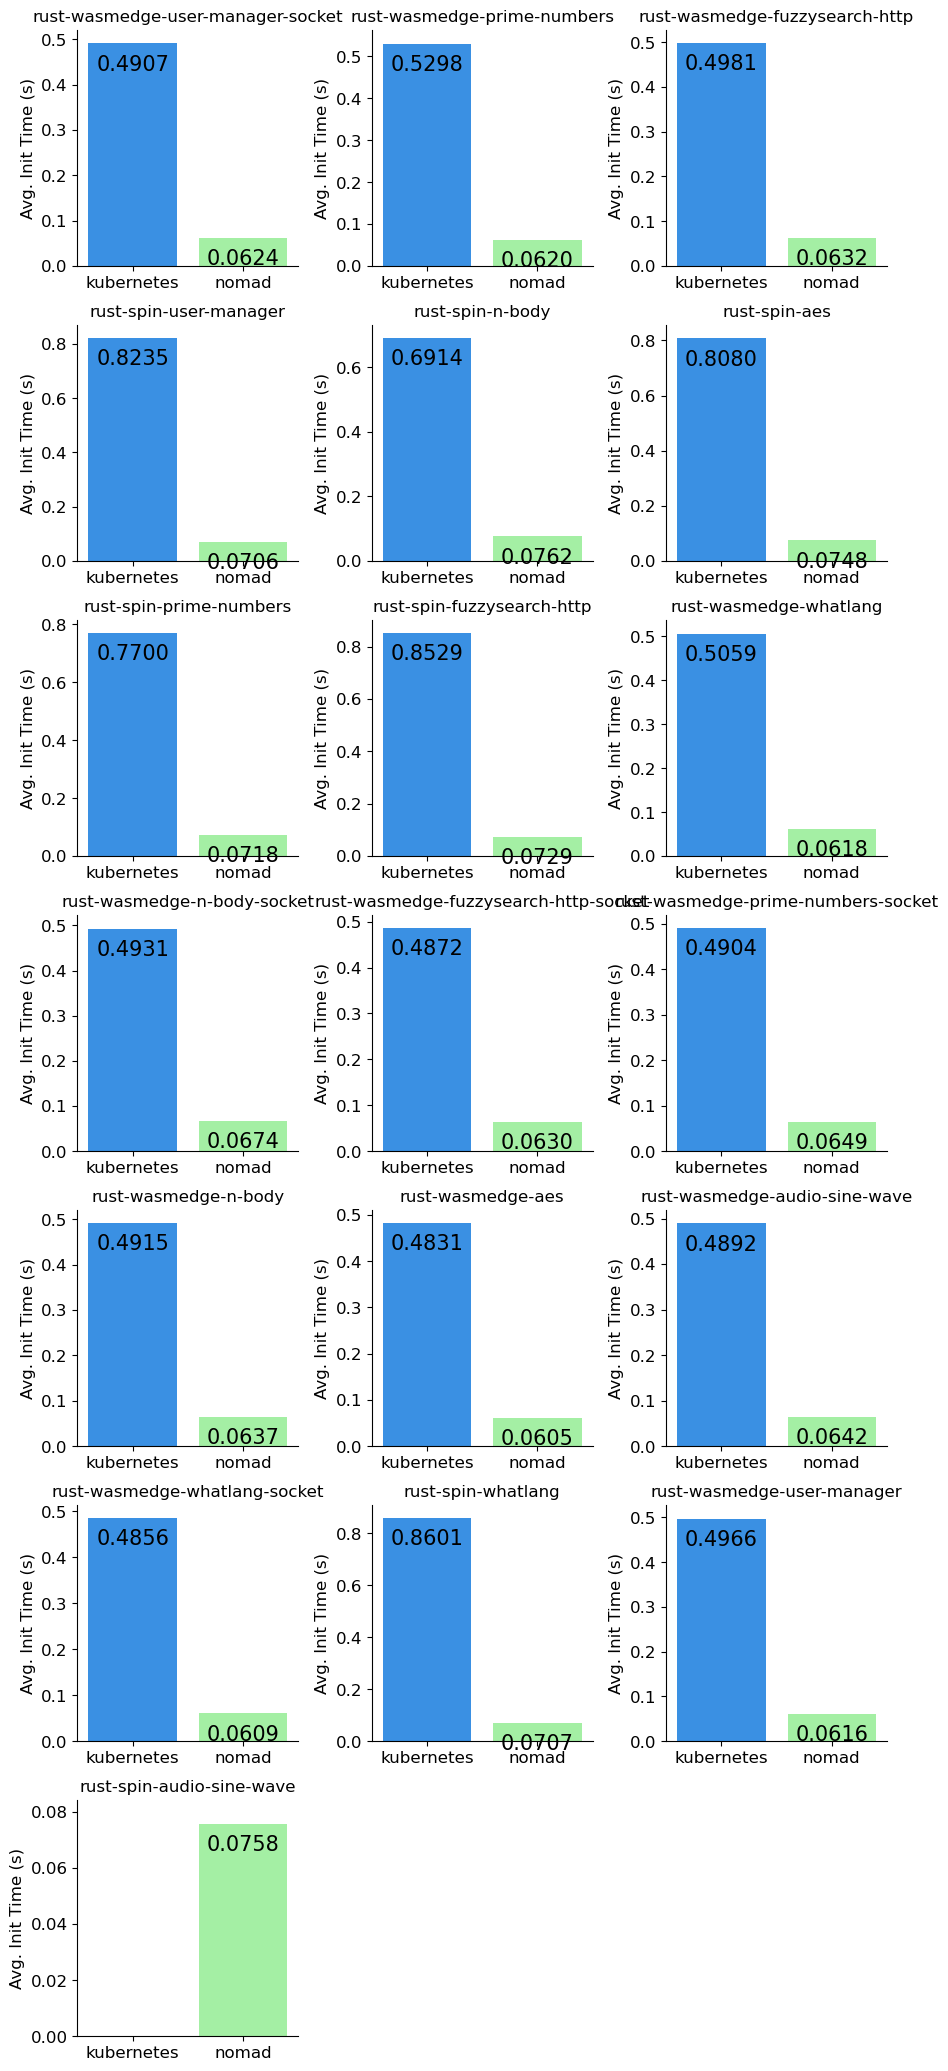

In [51]:
deployment_time_avg_bar_plot = sns.FacetGrid(df_deployment_time_all, col="test_name", hue='batch', col_wrap=3, sharey=False, palette=['dodgerblue', 'palegreen', 'darkorange'],
                                                  sharex=False)
deployment_time_avg_bar_plot = deployment_time_avg_bar_plot.map(sns.barplot, 'batch', 'init_time',
                                                                          order=['kubernetes', 'nomad'], errwidth=0)
deployment_time_avg_bar_plot.set_titles('{col_name}', size=12)
deployment_time_avg_bar_plot.fig.tight_layout(w_pad=3)
for ax in deployment_time_avg_bar_plot.axes.ravel():
    ax.set_ylabel('Avg. Init Time (s)', fontsize=12)
    ax.set_xlabel('')
    ax.tick_params(labelsize=12)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=15)
plt.show()

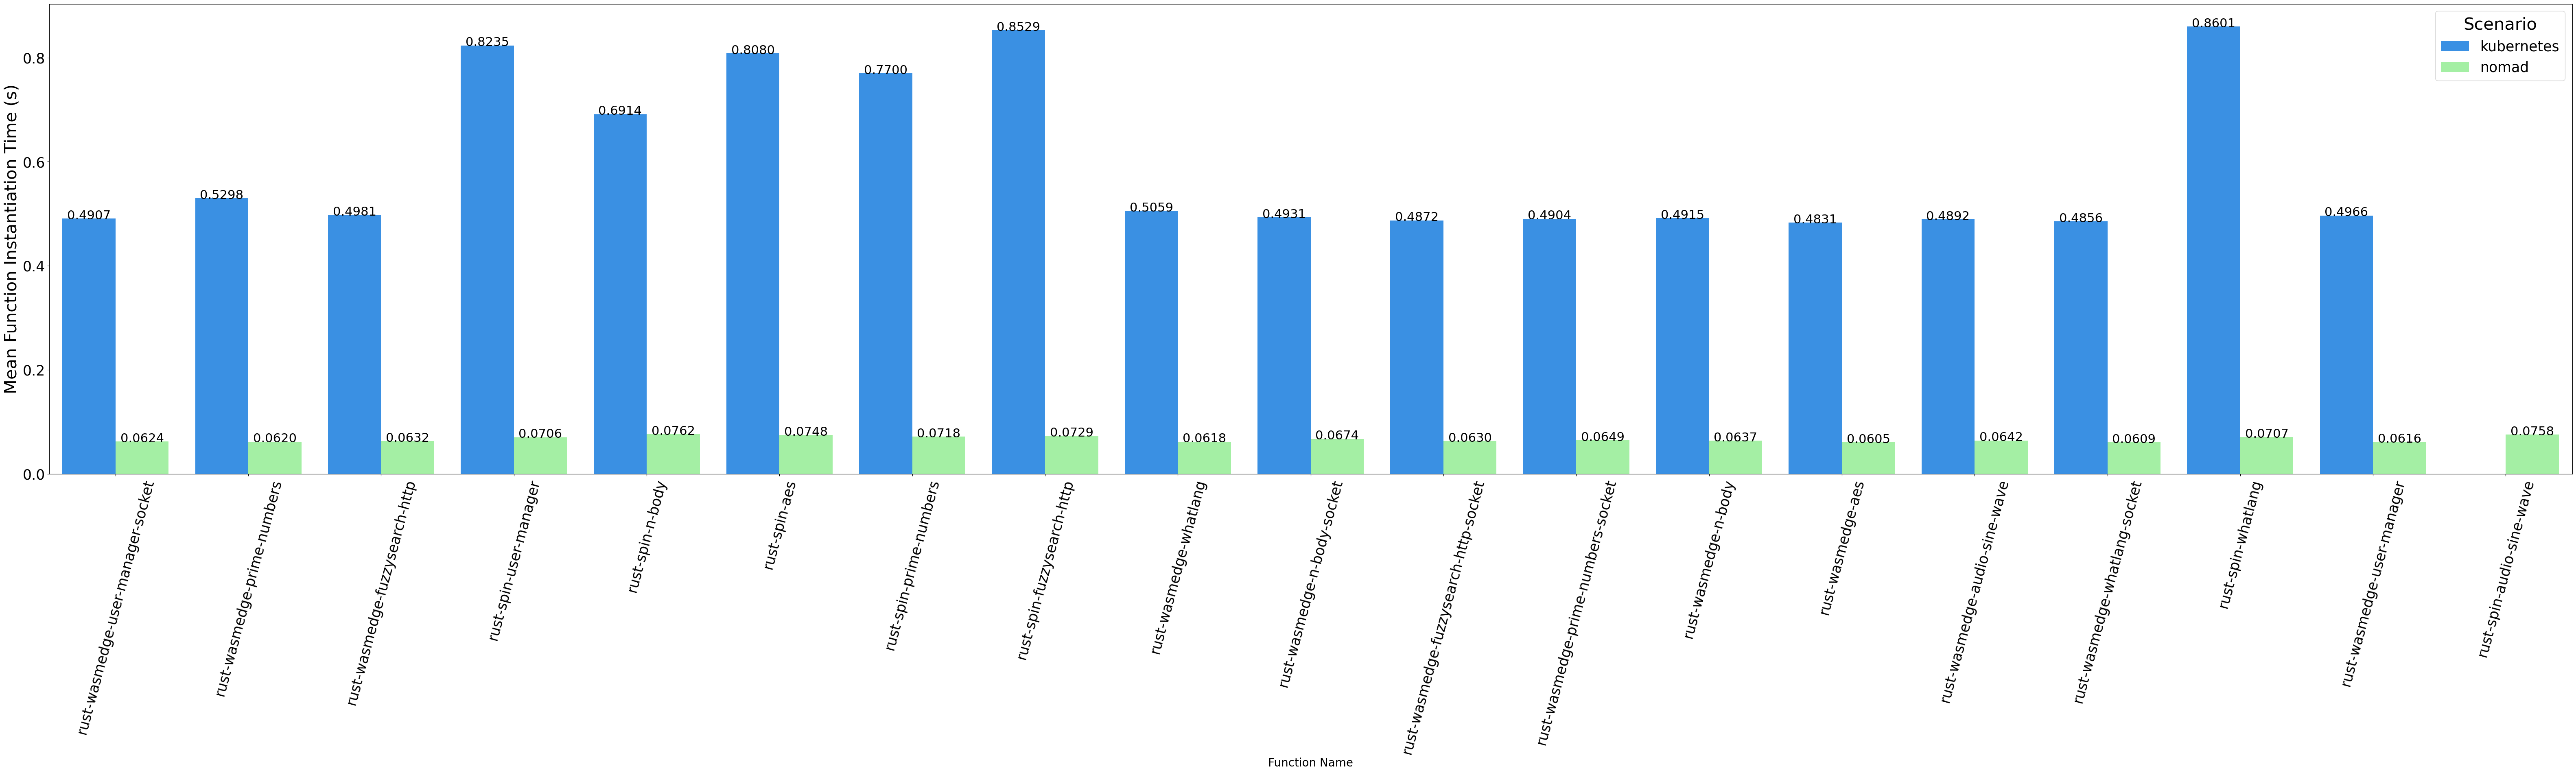

In [27]:
fig = plt.figure(figsize=(80,15))
sns.set_palette(['dodgerblue', 'palegreen', 'darkorange'])
pl4 = sns.barplot(data=df_deployment_time_all, y="init_time", x="test_name", hue='batch',errorbar=None)

pl4.set_xlabel('Function Name', fontsize=20)
pl4.set_ylabel('Mean Function Instantiation Time (s)', fontsize=30)
pl4.tick_params(labelsize=25)
plt.xticks(rotation=75)
legend = pl4.legend(title='Scenario', fontsize=25, loc='upper right')
plt.setp(legend.get_title(),fontsize=30)


for ax in pl4.patches:
    pl4.annotate(format(ax.get_height(), '.4f'), (ax.get_x() + ax.get_width() / 2., ax.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=22)

fig = pl4.get_figure()
fig.savefig('graphs/03-function-instantiation-time.png', bbox_inches='tight', dpi=300)




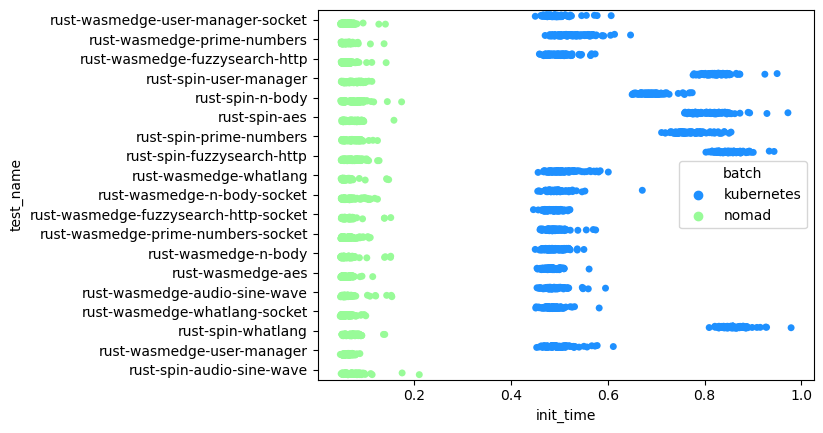

In [28]:
bplot4 = sns.stripplot(data=df_deployment_time_all, y='test_name', x='init_time', hue='batch', dodge=True, jitter=True)

In [22]:
for test in TEST_NAMES:
    tmp_std_kubernetes = df_deployment_time_all[(df_deployment_time_all.test_name == test) & (df_deployment_time_all.batch=='kubernetes')]['init_time'].std()
    tmp_std_nomad = df_deployment_time_all[(df_deployment_time_all.test_name == test) & (df_deployment_time_all.batch=='nomad')]['init_time'].std()
    print(f'STD - [{test}] kubernetes <= nomad: {tmp_std_kubernetes<=tmp_std_nomad}, {round(tmp_std_kubernetes,4)}<={round(tmp_std_nomad,4)}')

STD - [rust-wasmedge-fuzzysearch-http] kubernetes <= nomad: False, 0.0232<=0.0131
STD - [rust-spin-whatlang] kubernetes <= nomad: False, 0.025<=0.0154
STD - [rust-spin-user-manager] kubernetes <= nomad: False, 0.0263<=0.0151
STD - [rust-spin-n-body] kubernetes <= nomad: False, 0.0256<=0.0195
STD - [rust-spin-aes] kubernetes <= nomad: False, 0.0357<=0.0153
STD - [rust-spin-prime-numbers] kubernetes <= nomad: False, 0.0305<=0.0153
STD - [rust-spin-fuzzysearch-http] kubernetes <= nomad: False, 0.0256<=0.0166
STD - [rust-spin-audio-sine-wave] kubernetes <= nomad: False, nan<=0.0217
STD - [rust-wasmedge-whatlang] kubernetes <= nomad: False, 0.0294<=0.0167
STD - [rust-wasmedge-user-manager] kubernetes <= nomad: False, 0.026<=0.0079
STD - [rust-wasmedge-n-body-socket] kubernetes <= nomad: False, 0.0243<=0.0175
STD - [rust-wasmedge-fuzzysearch-http-socket] kubernetes <= nomad: True, 0.0137<=0.0164
STD - [rust-wasmedge-whatlang-socket] kubernetes <= nomad: False, 0.0173<=0.0109
STD - [rust-wasm